In [1]:
import torch.nn as nn
import torch
from autoencoders.learned_dict import TiedSAE, UntiedSAE
import matplotlib.pyplot as plt
from util import ActivationDataset
import seaborn as sns
import numpy as np
from transformers import ViTForImageClassification, ViTImageProcessor
import torchvision.transforms as transforms
from torch.utils.data import DataLoader

from datasets import load_dataset
from torch.utils.data import Dataset, DataLoader


/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/transformers/utils/hub.py:124: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
2024-03-09 19:09:55.169862: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-09 19:09:55.169910: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-09 19:09:55.171852: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-09 19:09:56.447452: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# tied SAE

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#initiate SAE
encoder = torch.randn((7680,768))
nn.init.xavier_uniform(encoder)
encoder_bias = torch.zeros(7680)


tied_sae = TiedSAE(encoder, encoder_bias)
tied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
tied_sae.to_device(device)

/tmp/ipykernel_2210702/2300273816.py:5: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(encoder)


<Axes: >

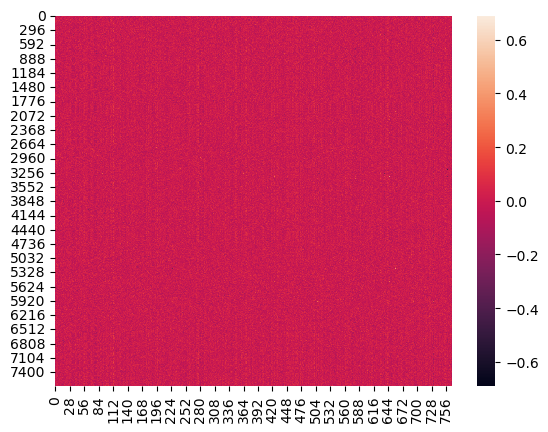

In [3]:
sns.heatmap(tied_sae.get_learned_dict().cpu().detach().numpy())

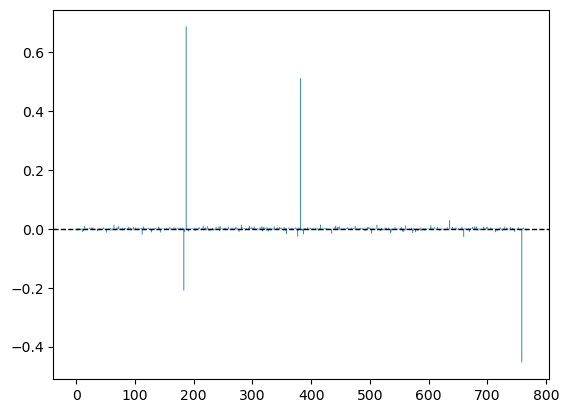

In [4]:
act = tied_sae.get_learned_dict().cpu().detach().numpy()[880,:] # most activated mid layers
plt.bar(range(len(act)), act, snap=False,width=1.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

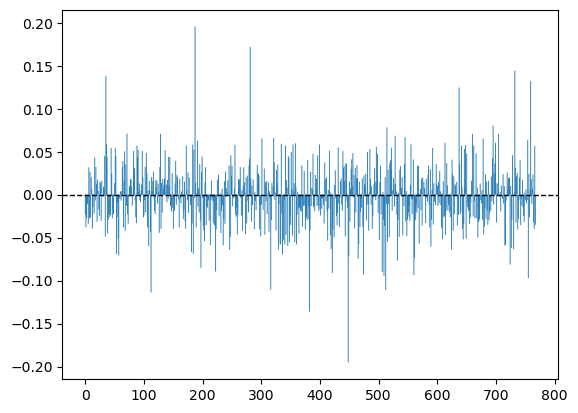

In [5]:
act = tied_sae.get_learned_dict().cpu().detach().numpy()[4753,:] # most activated early layers
plt.bar(range(len(act)), act, snap=False,width=1.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

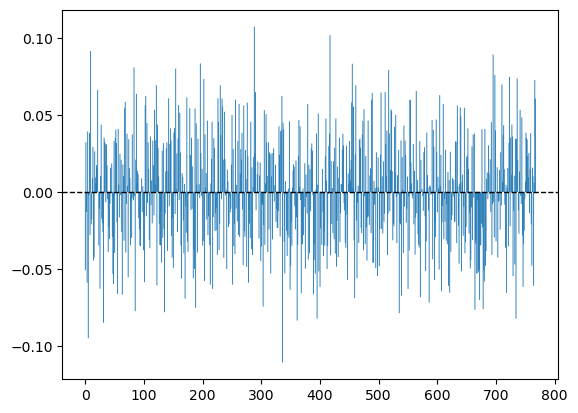

In [6]:
act = tied_sae.get_learned_dict().cpu().detach().numpy()[5115,:] # most activated later layers for class 0
plt.bar(range(len(act)), act, snap=False,width=1.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=1)

(array([2.400e+01, 2.150e+02, 7.160e+02, 1.239e+03, 1.317e+03, 1.114e+03,
        8.780e+02, 6.610e+02, 4.480e+02, 2.910e+02, 1.490e+02, 1.020e+02,
        9.800e+01, 5.700e+01, 4.300e+01, 3.900e+01, 2.200e+01, 3.400e+01,
        1.700e+01, 2.400e+01, 1.700e+01, 1.500e+01, 1.000e+01, 1.300e+01,
        1.100e+01, 7.000e+00, 5.000e+00, 1.400e+01, 2.000e+00, 5.000e+00,
        6.000e+00, 6.000e+00, 5.000e+00, 3.000e+00, 3.000e+00, 2.000e+00,
        0.000e+00, 4.000e+00, 1.000e+00, 3.000e+00, 3.000e+00, 3.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 2.000e+00, 1.000e+00, 2.000e+00,
        4.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 3.000e+00, 0.000e+00,
        3.000e+00, 1.000e+00, 0.000e+00, 3.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 4.000e+00,
        0.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00,
        2.000e+00, 0.000e+00, 0.000e+00, 2.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

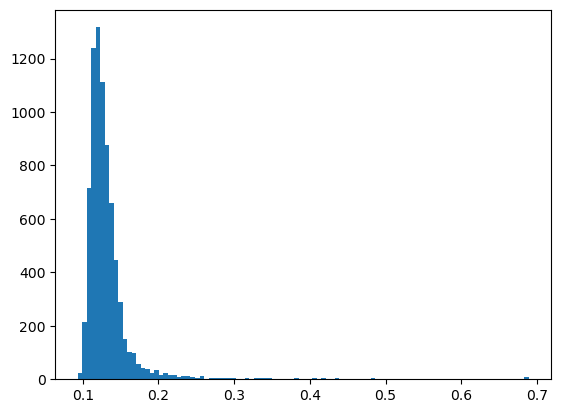

In [7]:
max_absolute_activation = []
for i in range(7680):
    weight = tied_sae.get_learned_dict().cpu().detach().numpy()[i,:]
    weight = np.abs(weight)
    max_absolute_activation.append(max(weight))
top_20_indices = np.argsort(max_absolute_activation)[-20:]
top_20_indices = top_20_indices[::-1]

plt.hist(max_absolute_activation, bins=100)

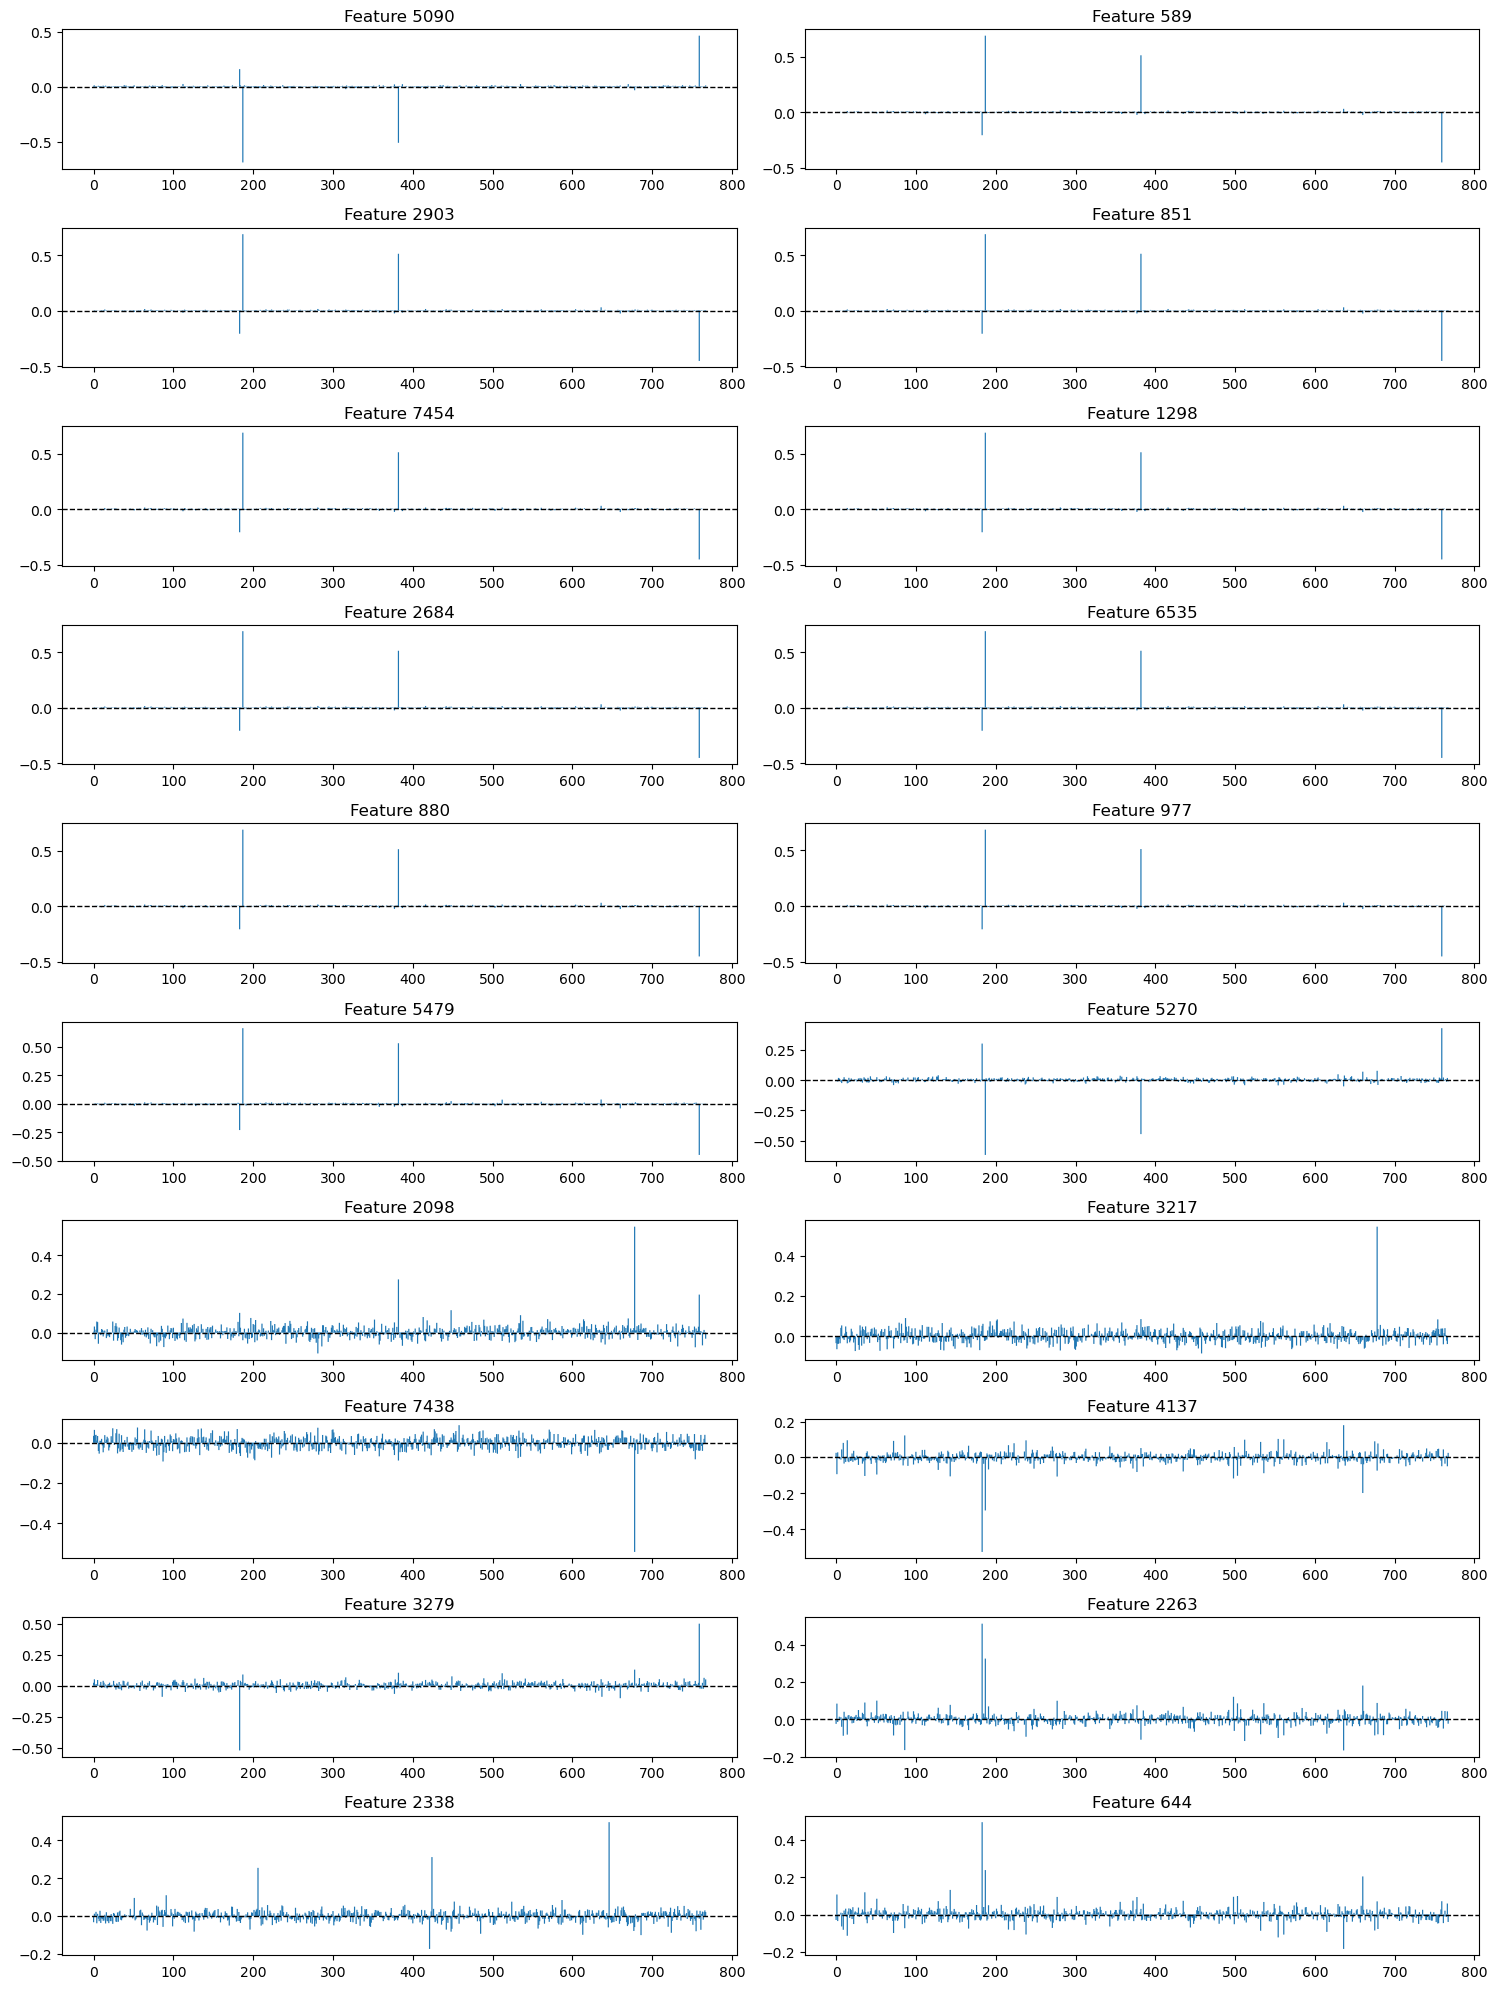

In [8]:
# top 20 max absolute activation
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = tied_sae.get_learned_dict().cpu().detach().numpy()[top_20_indices[i], :]
    ax.bar(range(len(act)), act, snap=False,width=1.5)
    ax.set_title(f"Feature {top_20_indices[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [9]:
# compute z score
z = []
for i in range(7680):
    weight = tied_sae.get_learned_dict().cpu().detach().numpy()[i,:]
    m = np.mean(tied_sae.get_learned_dict().cpu().detach().numpy(),axis=0)
    s = np.std(tied_sae.get_learned_dict().cpu().detach().numpy(), axis=0)
    z.append((weight-m)/s)


In [10]:
# max z score across features
max_z = []
for i in range(7680):
    abs_z = np.abs(z[i])
    max_z.append(max(abs_z))

top_20_z = np.argsort(max_z)[-20:]
top_20_z = top_20_z[::-1]

In [11]:
top_20_z 

array([ 589, 2903,  851, 7454, 1298, 2684, 6535,  880,  977, 5479, 5090,
       5270, 4137, 2098, 3279, 3217, 7438, 2263, 7582,  644])

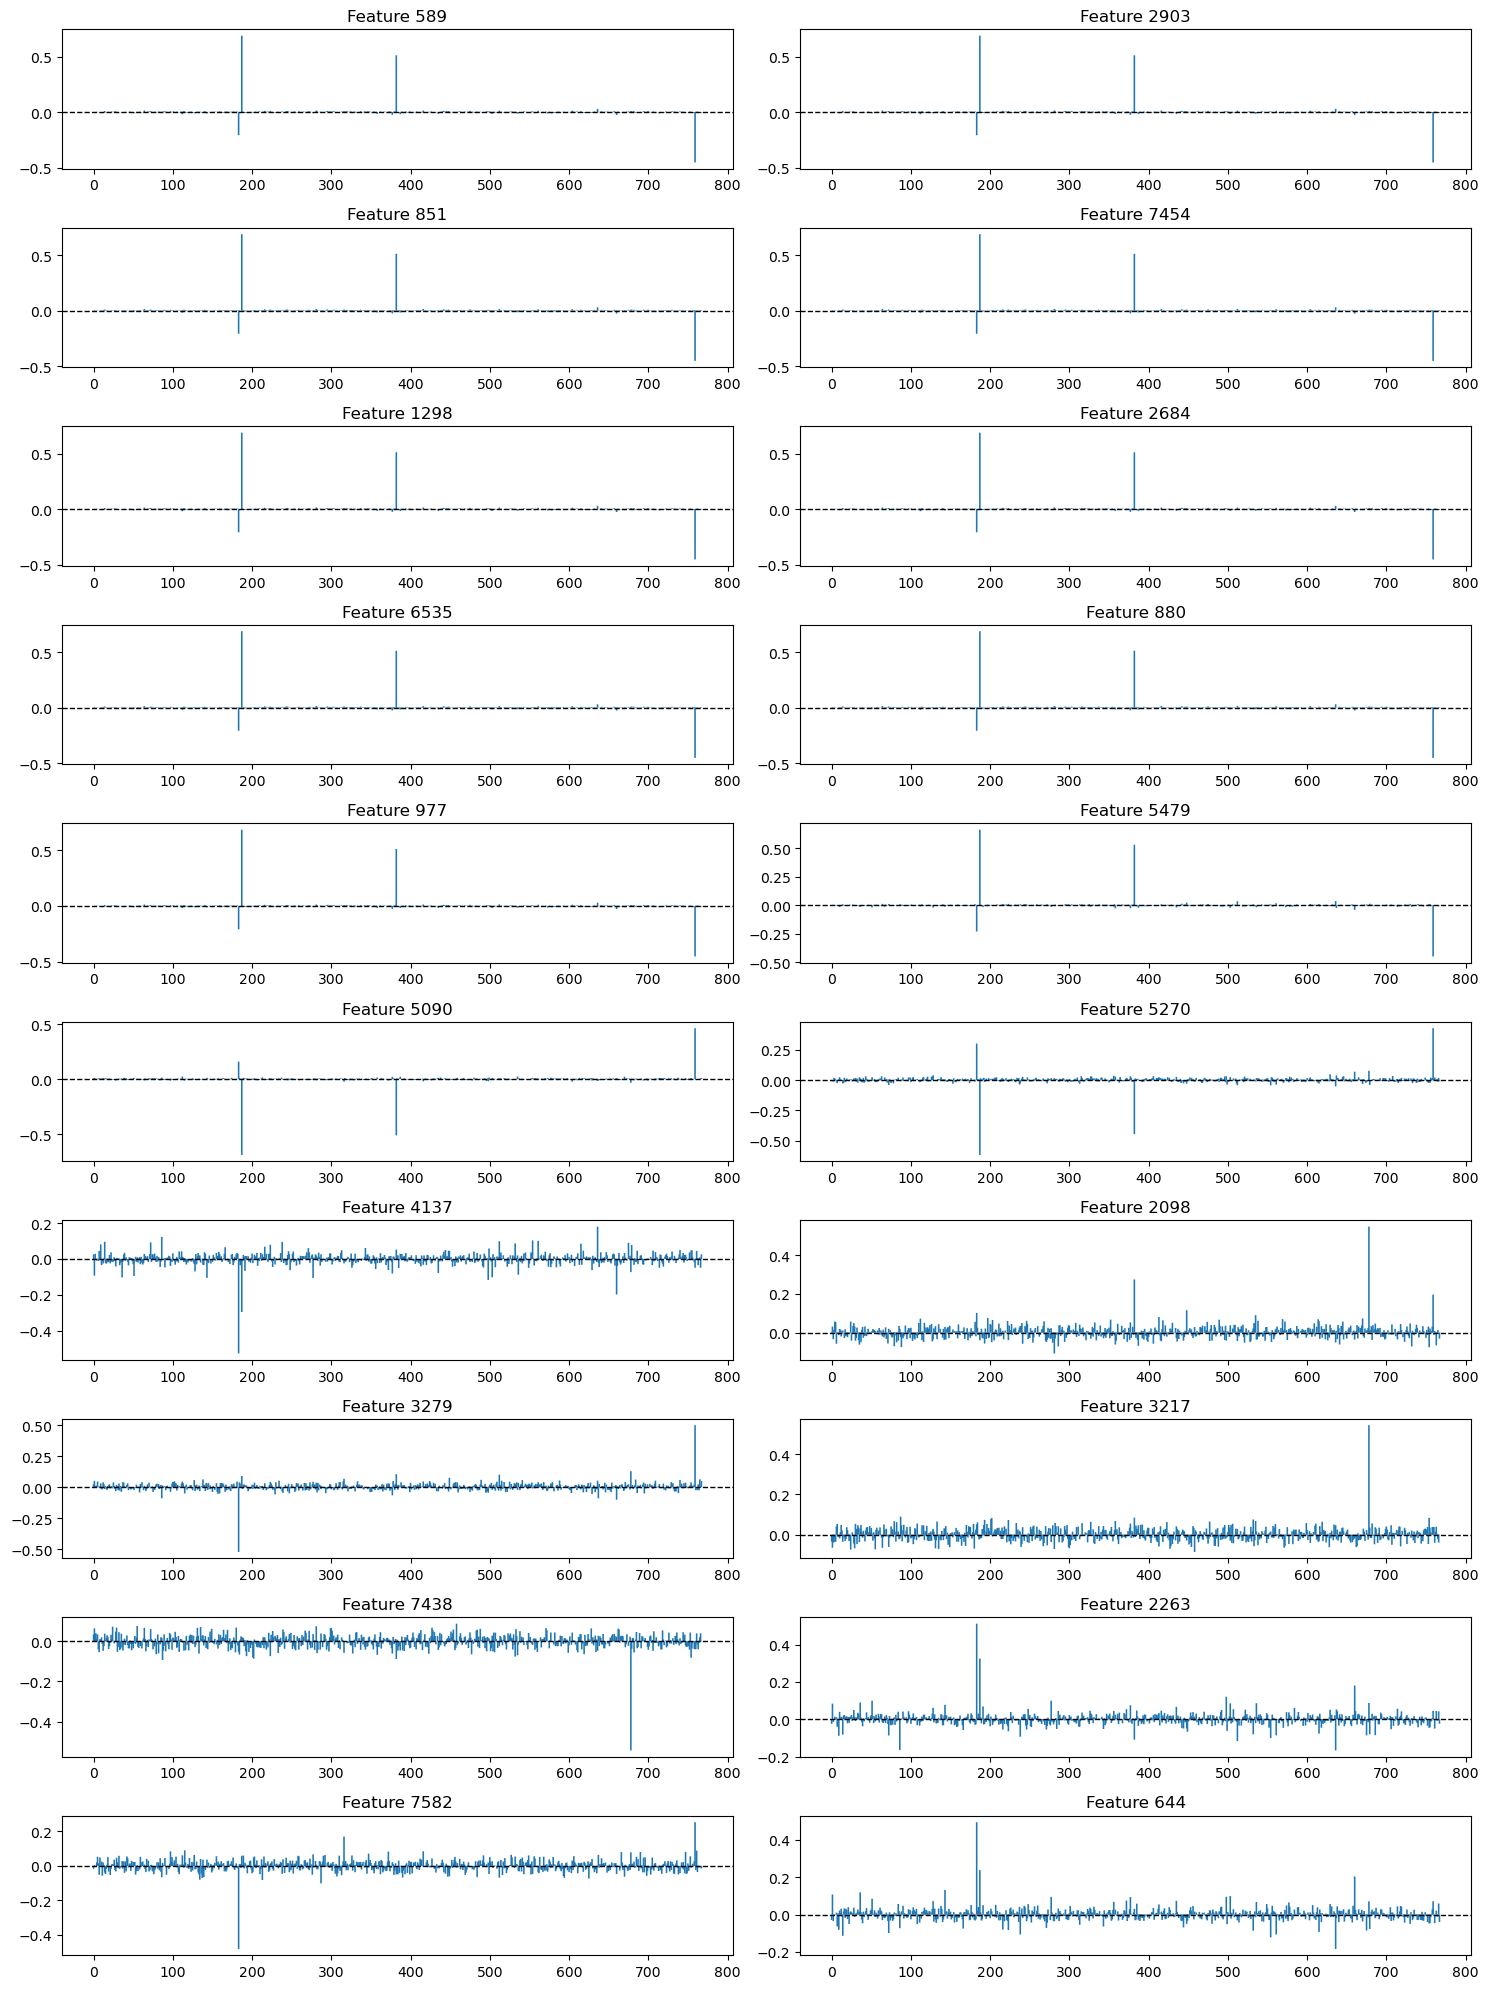

In [12]:
# top 20 max absolute z score
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = tied_sae.get_learned_dict().cpu().detach().numpy()[top_20_z[i],:]
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {top_20_z[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()



In [13]:
# compare average z scores
avg_z = []
for i in range(7680):
    abs_z = np.abs(z[i])
    avg_z.append(abs_z.mean())

top_20_z_avg = np.argsort(avg_z)[-20:]
top_20_z_avg = top_20_z_avg[::-1]

low_20_z_avg = np.argsort(avg_z)[:20]

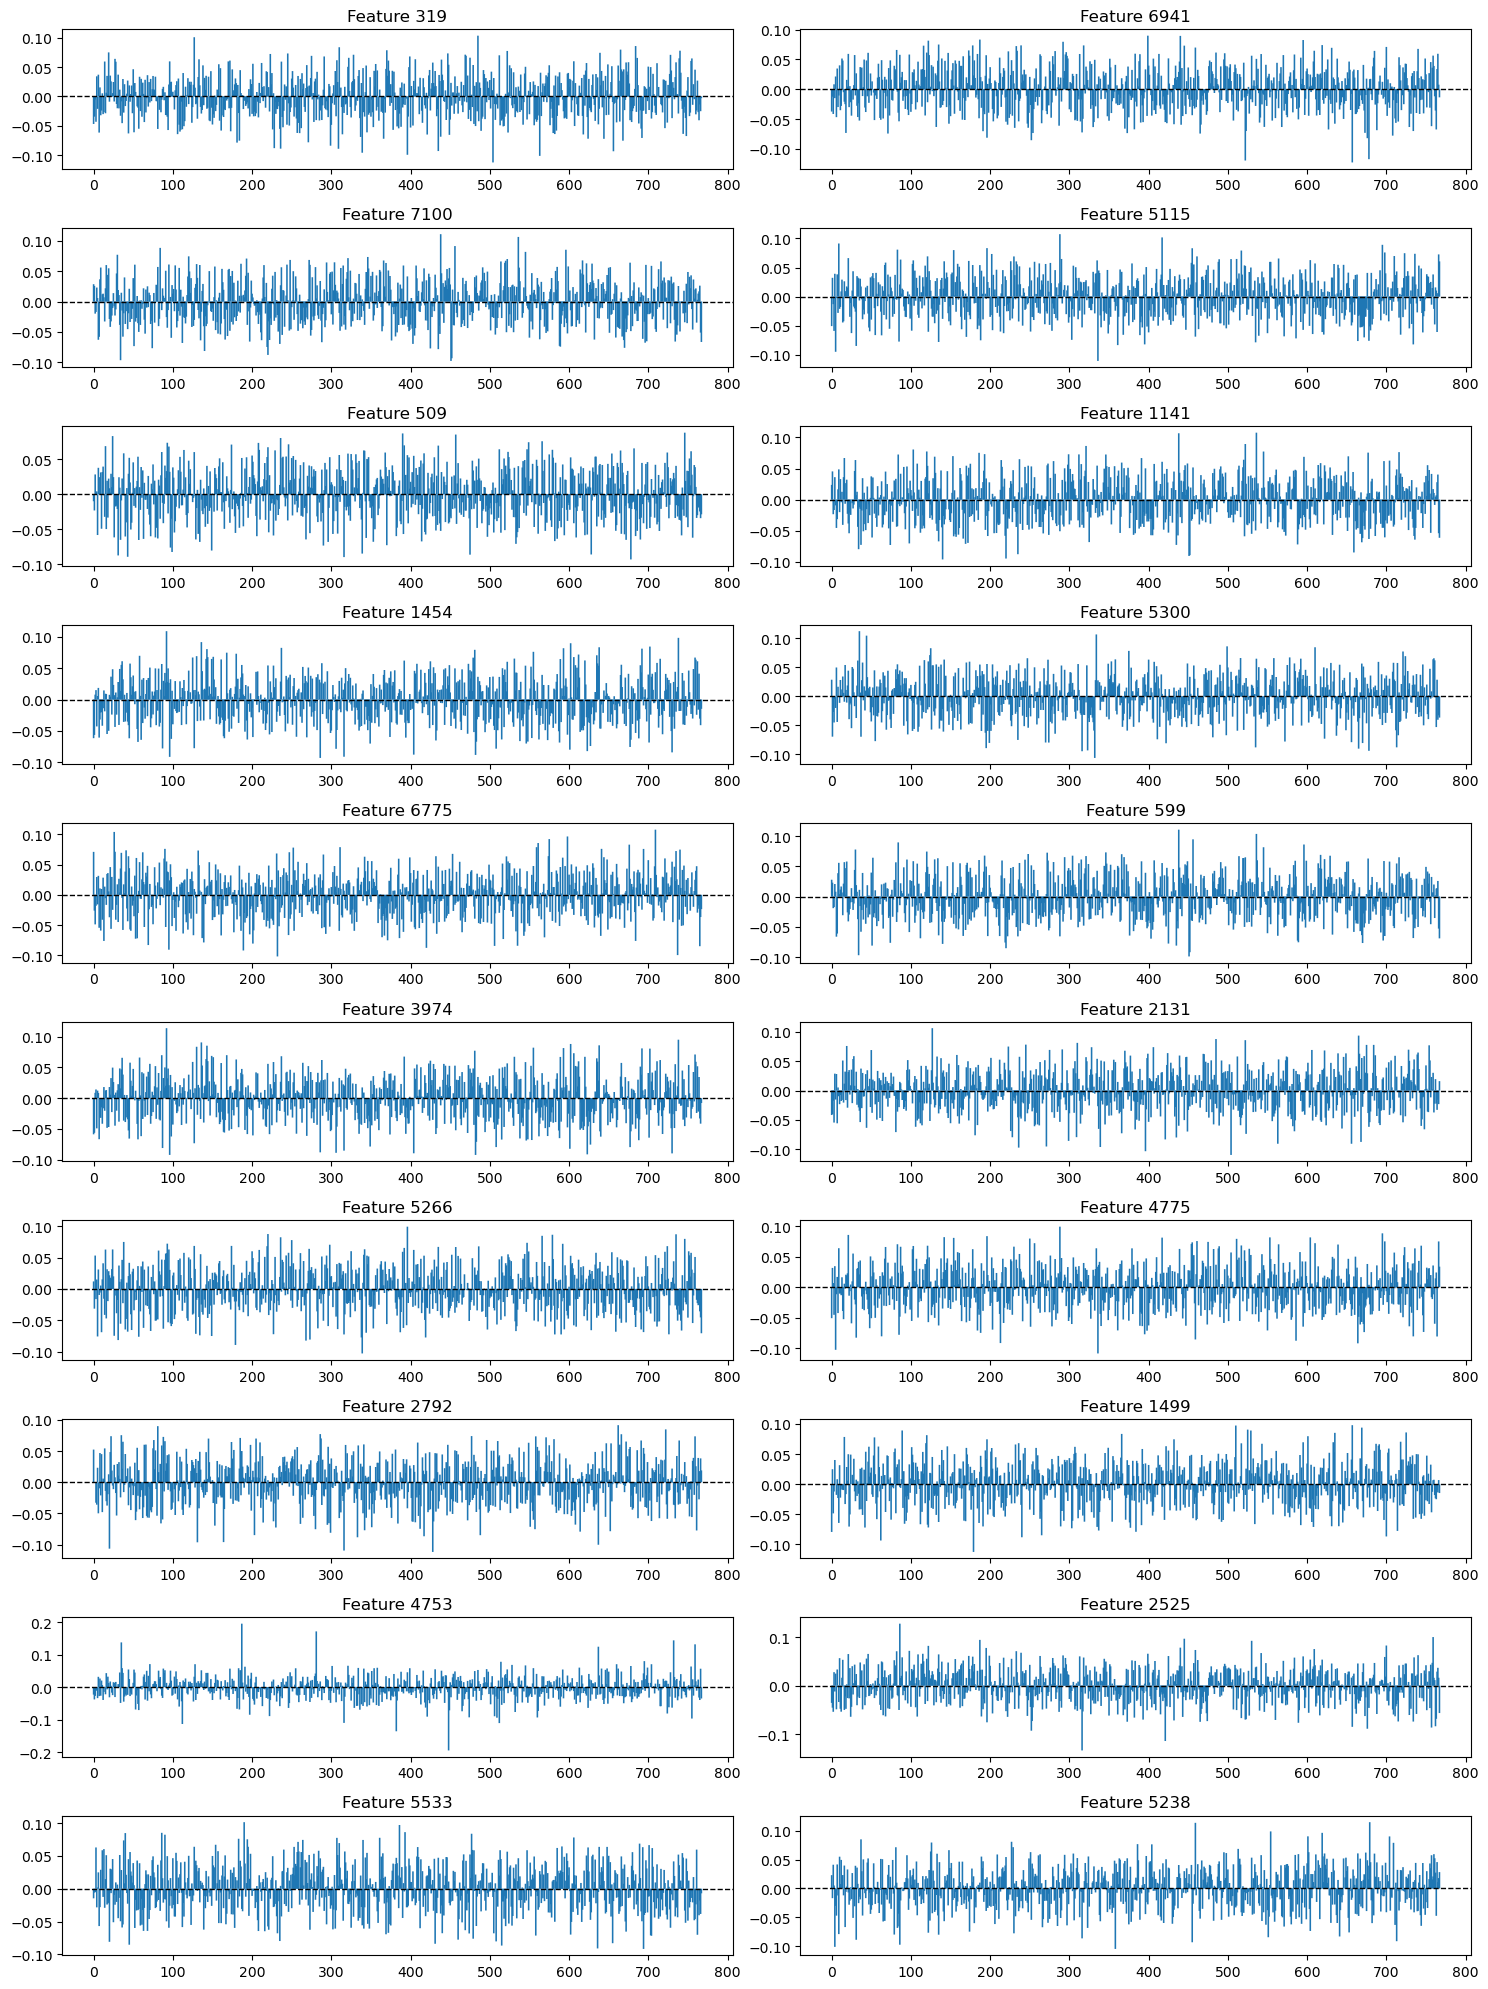

In [14]:
#top 20 average z score

fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = tied_sae.get_learned_dict().cpu().detach().numpy()[top_20_z_avg[i],:]
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {top_20_z_avg[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



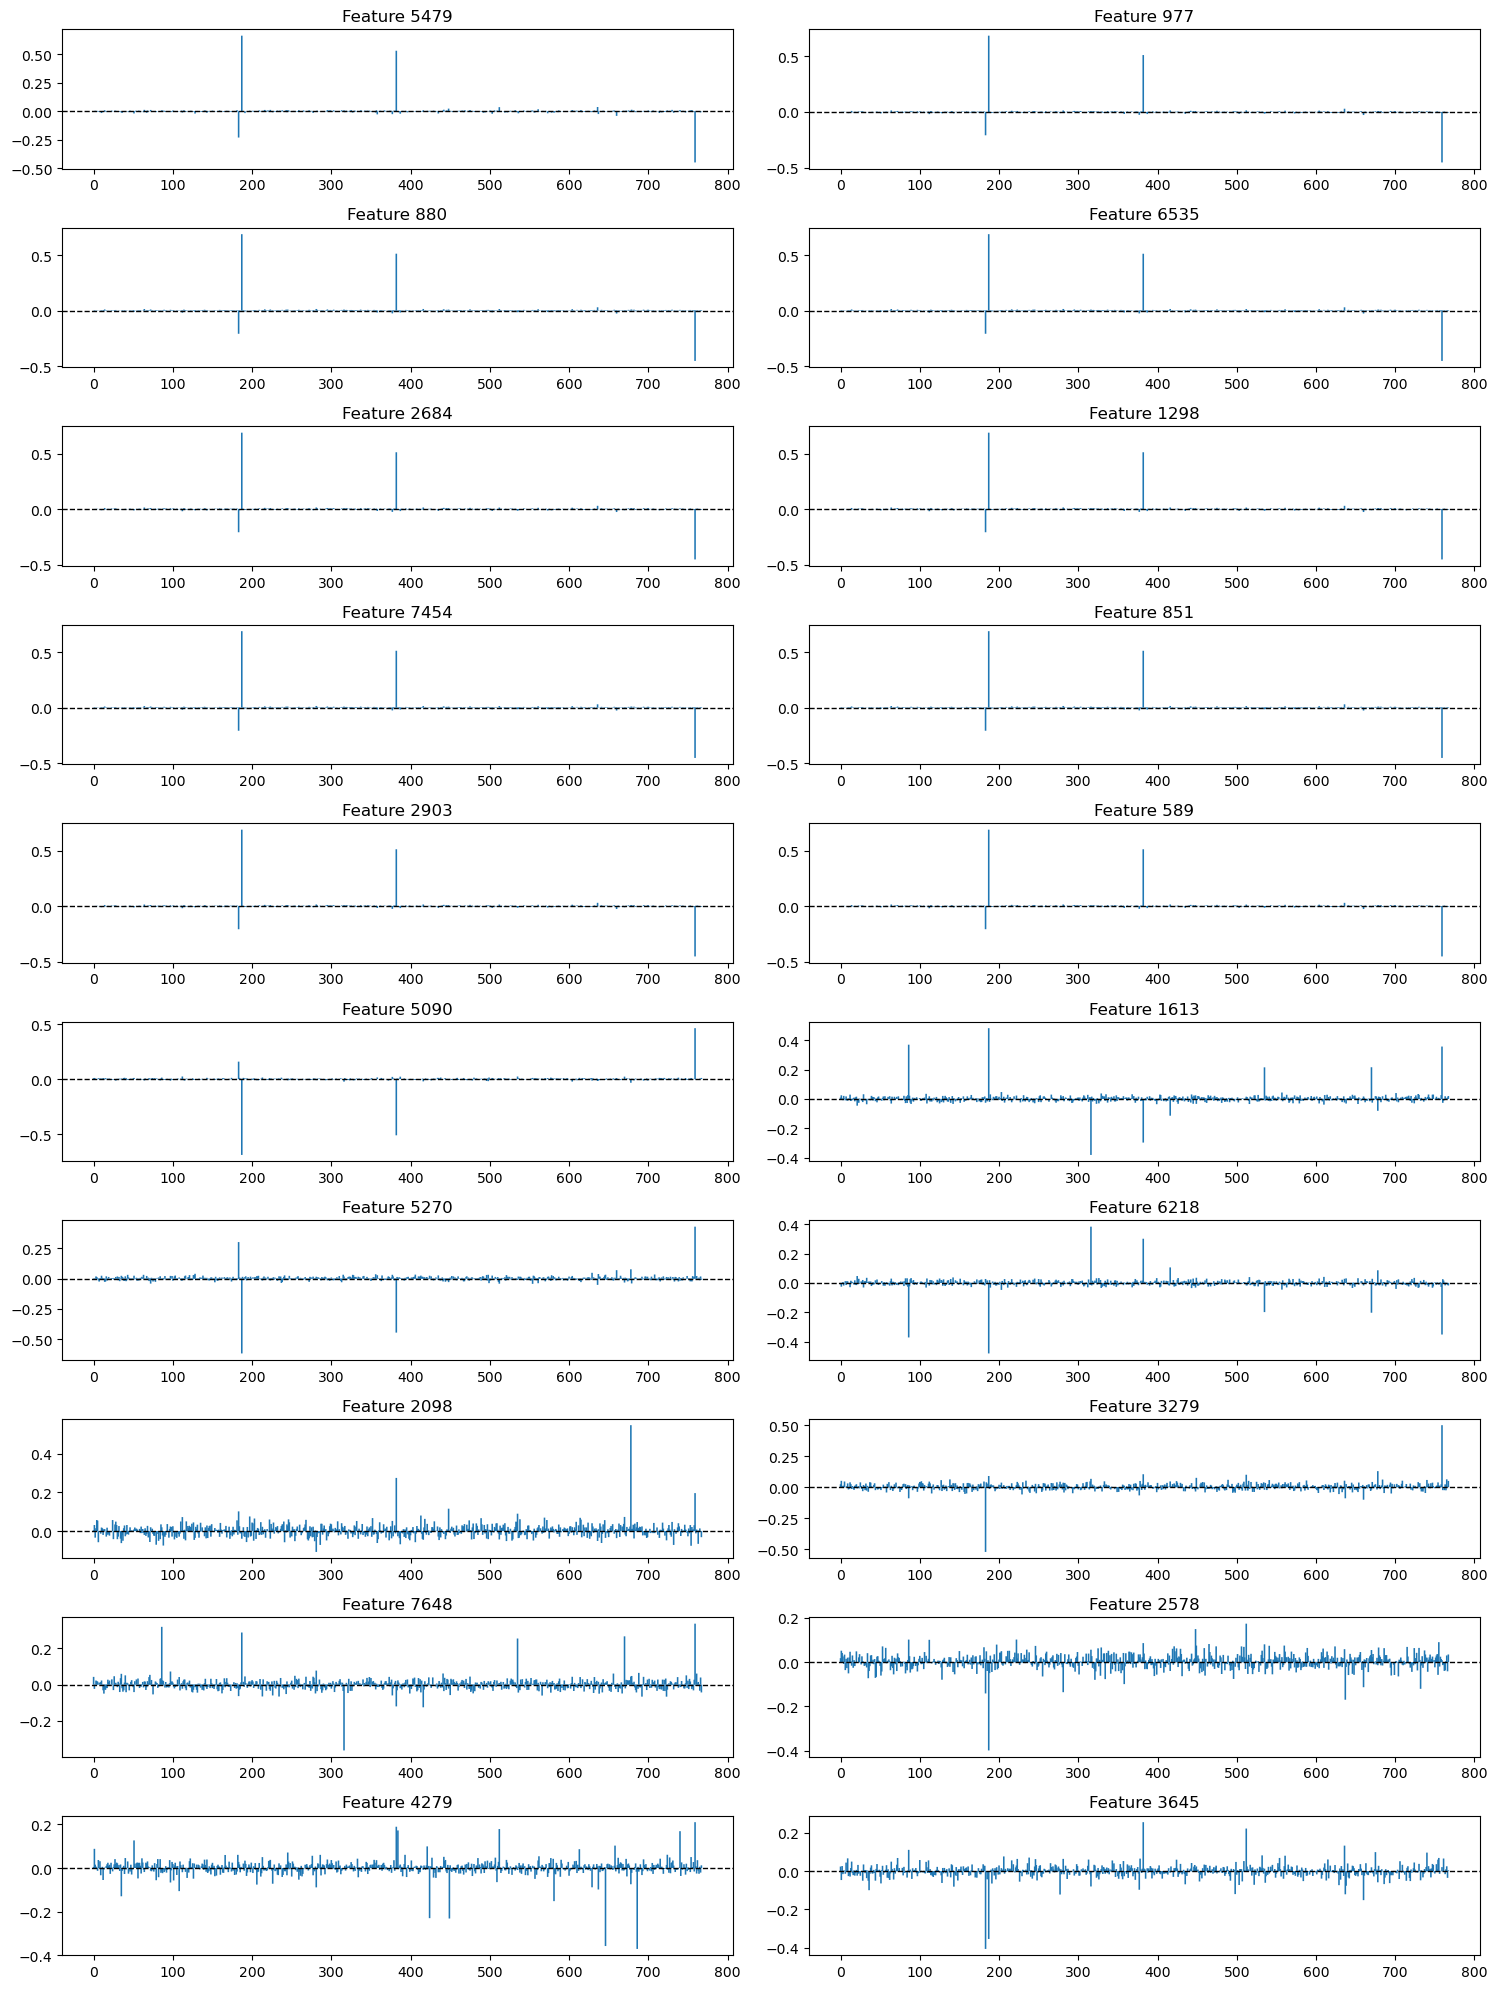

In [15]:
#botton 20 average z scores
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = tied_sae.get_learned_dict().cpu().detach().numpy()[low_20_z_avg[i],:]
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {low_20_z_avg[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



In [16]:
# cifar 10 activation plot for top 20 absolute activation, top/bottom 20 average zscores
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10',output_hidden_states=True)
model.eval()
processor = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
to_pil = transforms.ToPILImage()

/ceph/kikang/miniconda3/envs/interp/lib/python3.11/site-packages/torch/_utils.py:831: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()


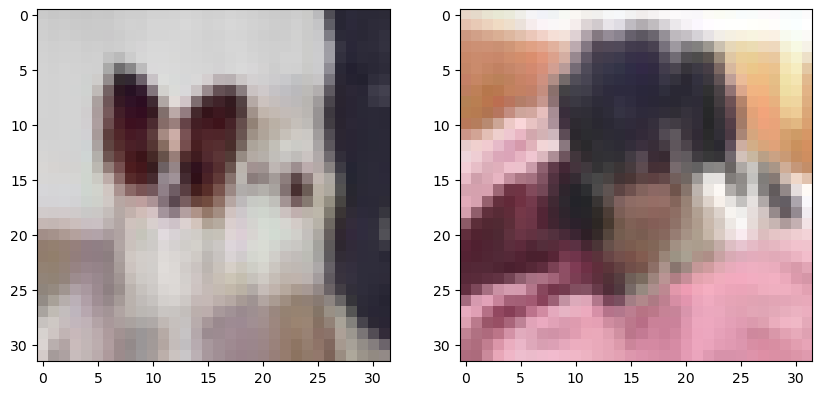

In [28]:
dataset = ActivationDataset('activations_cifar10_vit_b/cifar10_activations_5.h5','vit.encoder.layer.0.output')

data_loader = DataLoader(dataset, batch_size=32, shuffle=True)

input_image = next(iter(data_loader))[0][0]
input_image2 = next(iter(data_loader))[0][1]
fig, ax = plt.subplots(1, 2, figsize=(10, 5))
ax[0].imshow(input_image.permute(1,2,0))
ax[1].imshow(input_image2.permute(1,2,0))
plt.show()

inputs = processor(images=to_pil(input_image), return_tensors="pt")
inputs2 = processor(images=to_pil(input_image2), return_tensors="pt")

In [29]:
activation_inputs = model(**inputs)['hidden_states'][1:]
activation_inputs2 = model(**inputs2)['hidden_states'][1:]

In [30]:
activation = []
for i in range(12):
    activation.append(tied_sae.encode(activation_inputs[i].to(device)).squeeze(0))

activation2 = []
for i in range(12):
    activation2.append(tied_sae.encode(activation_inputs2[i].to(device)).squeeze(0))

## top 20 absolute activation

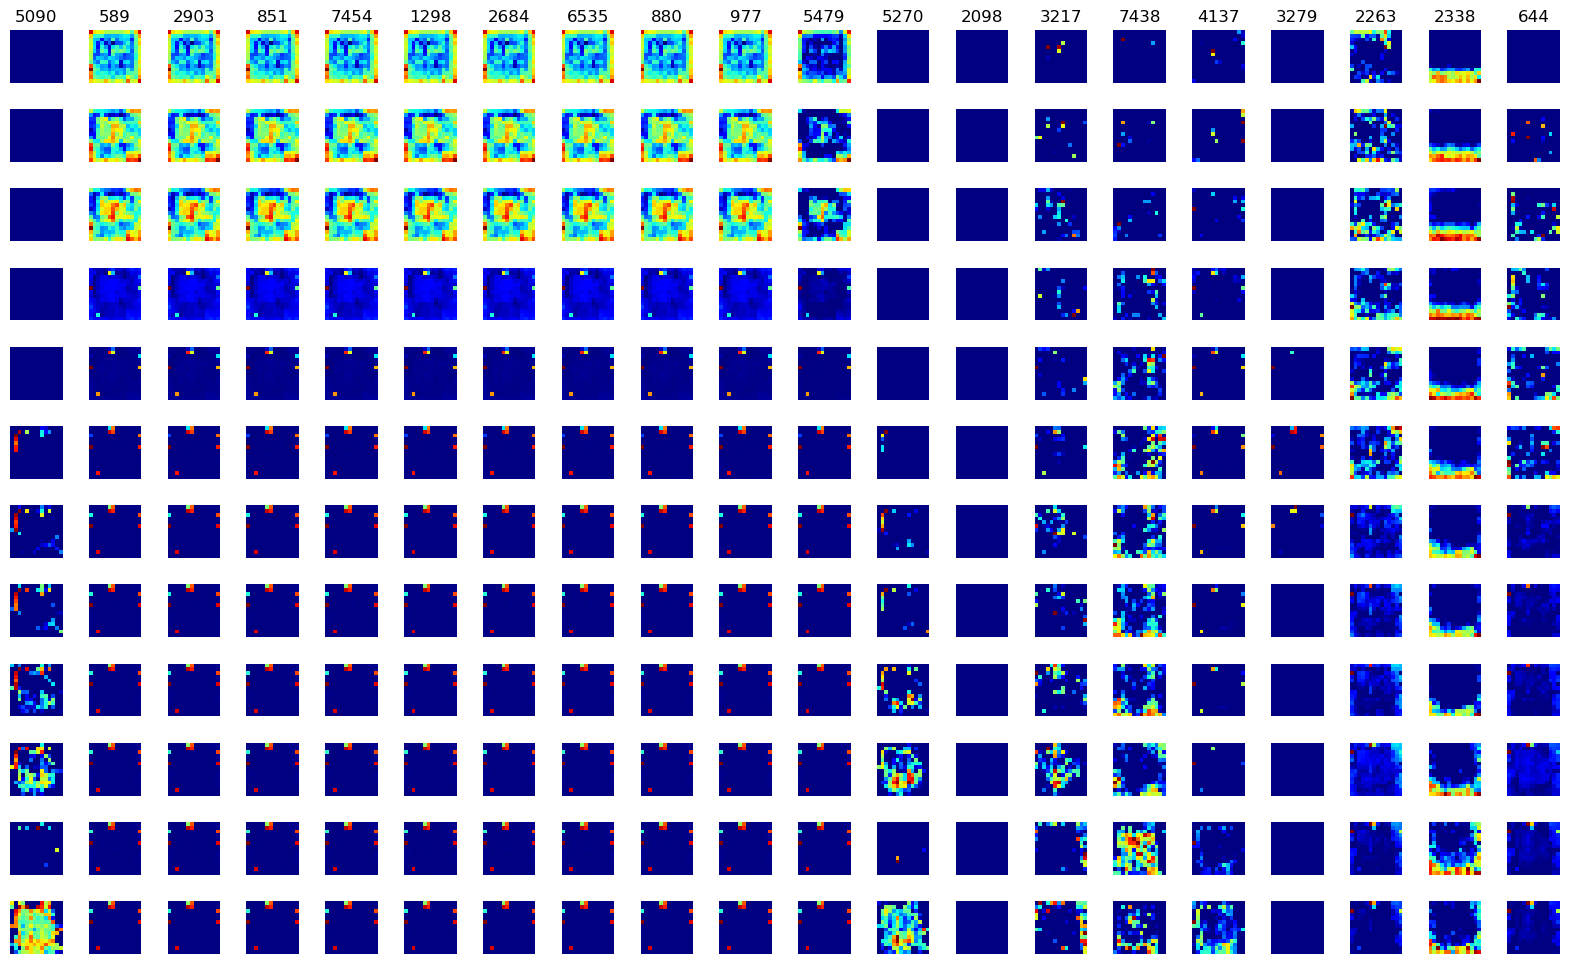

In [31]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = top_20_indices[j]
        sns.heatmap(activation[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


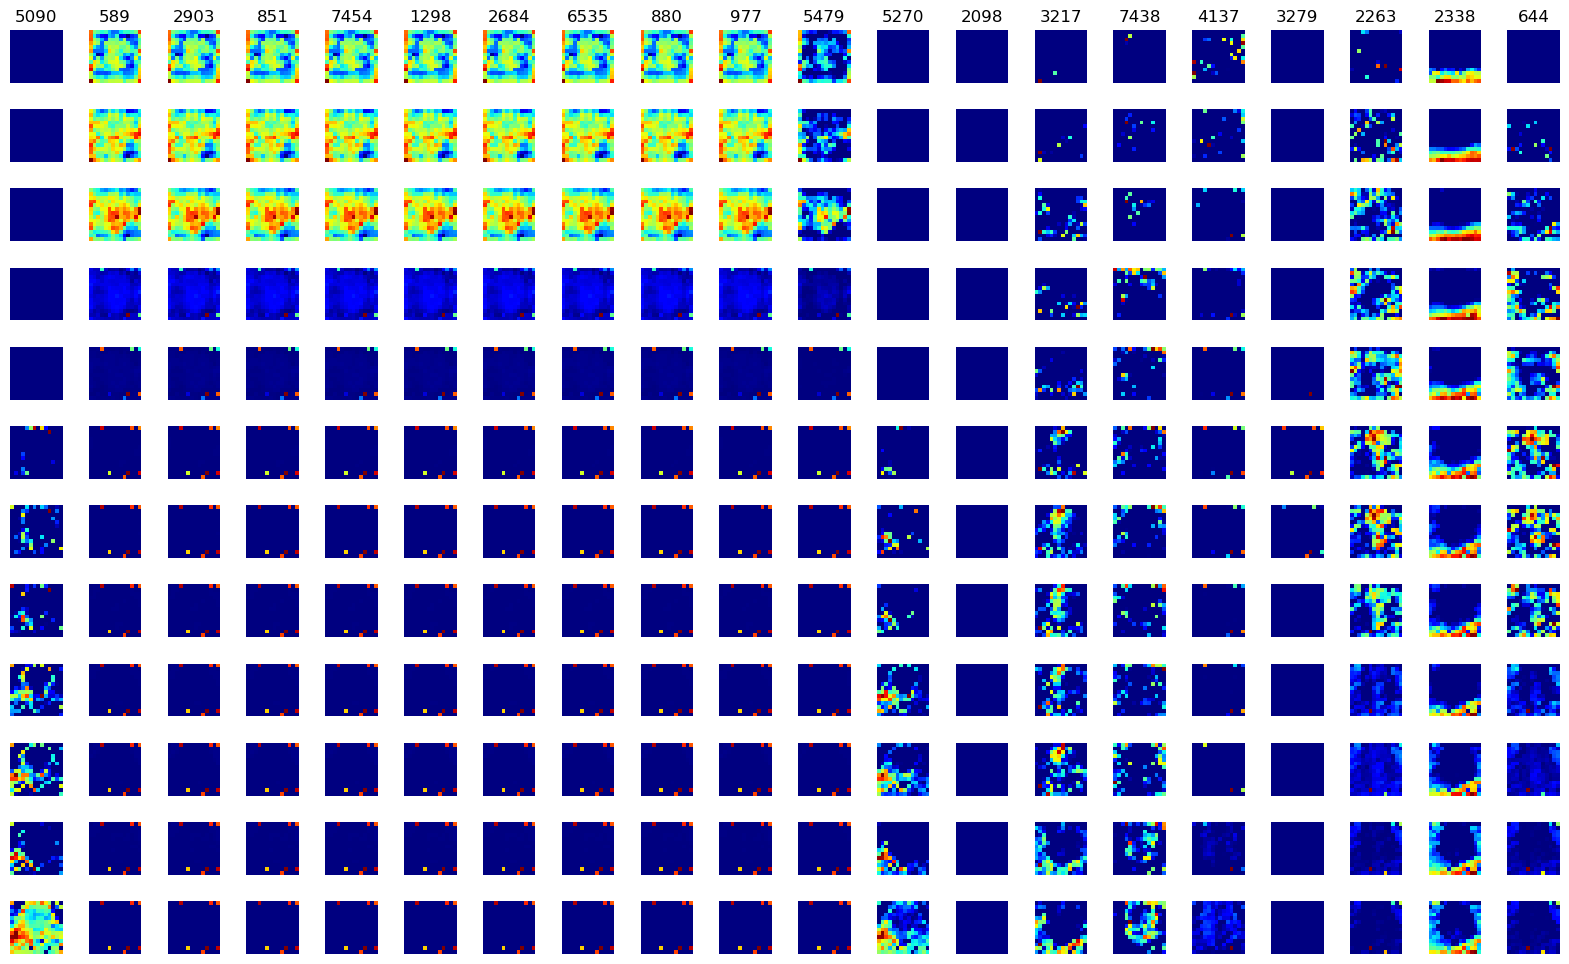

In [32]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = top_20_indices[j]
        sns.heatmap(activation2[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


## top 20 average z scores

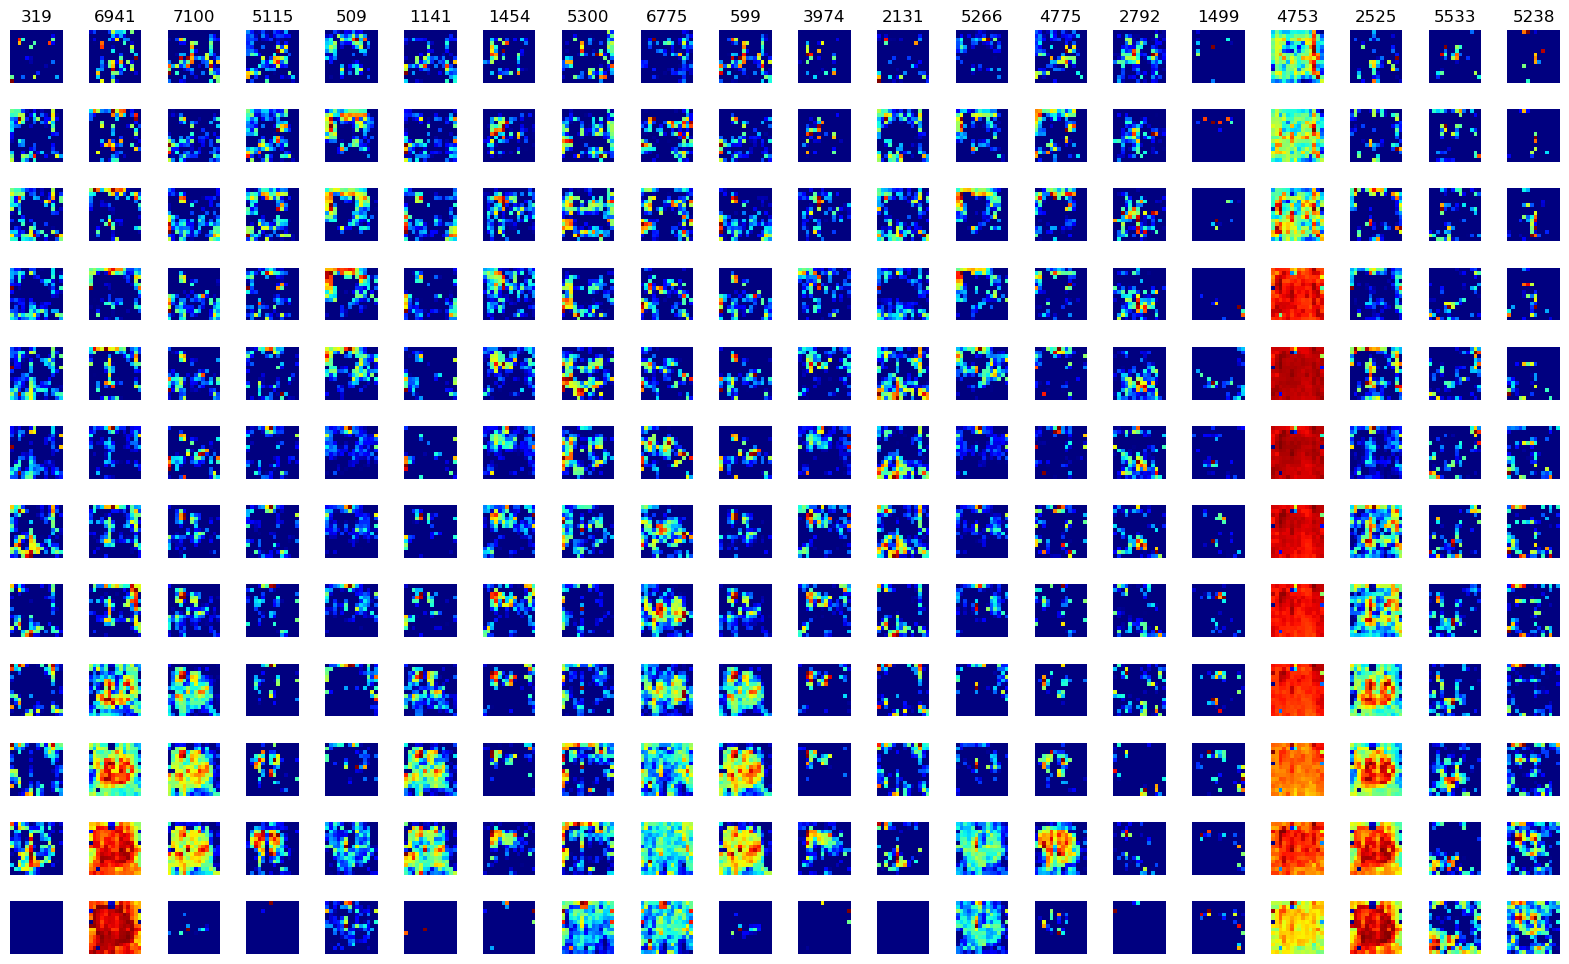

In [33]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = top_20_z_avg[j]
        sns.heatmap(activation[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


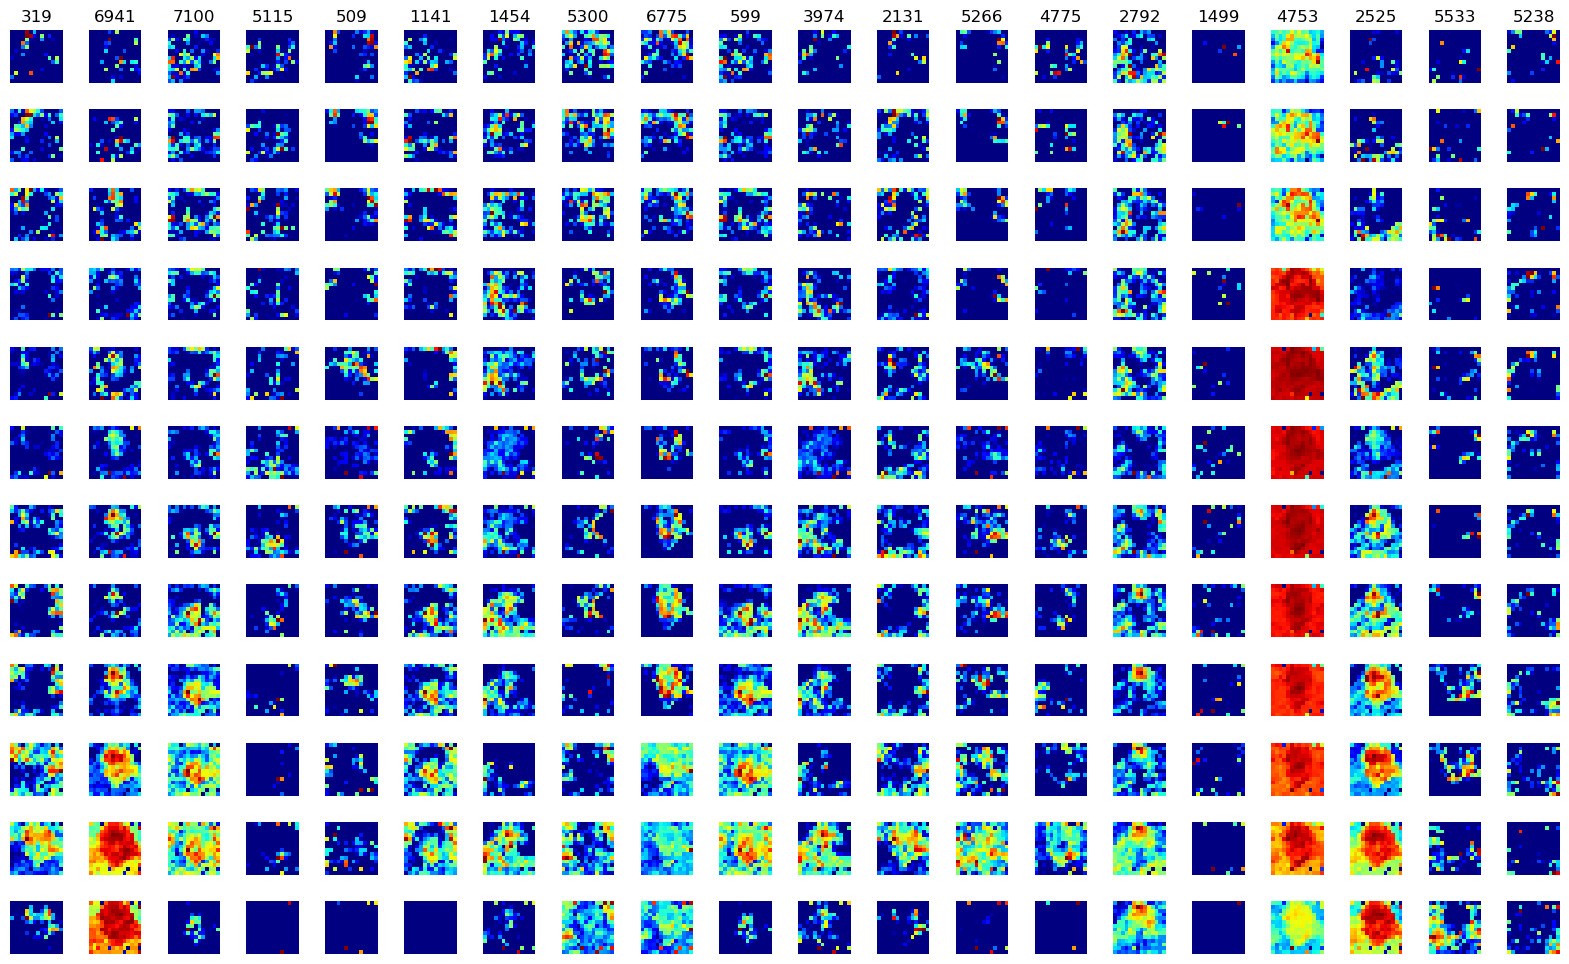

In [34]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = top_20_z_avg[j]
        sns.heatmap(activation2[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


## bottom 20 average z scores

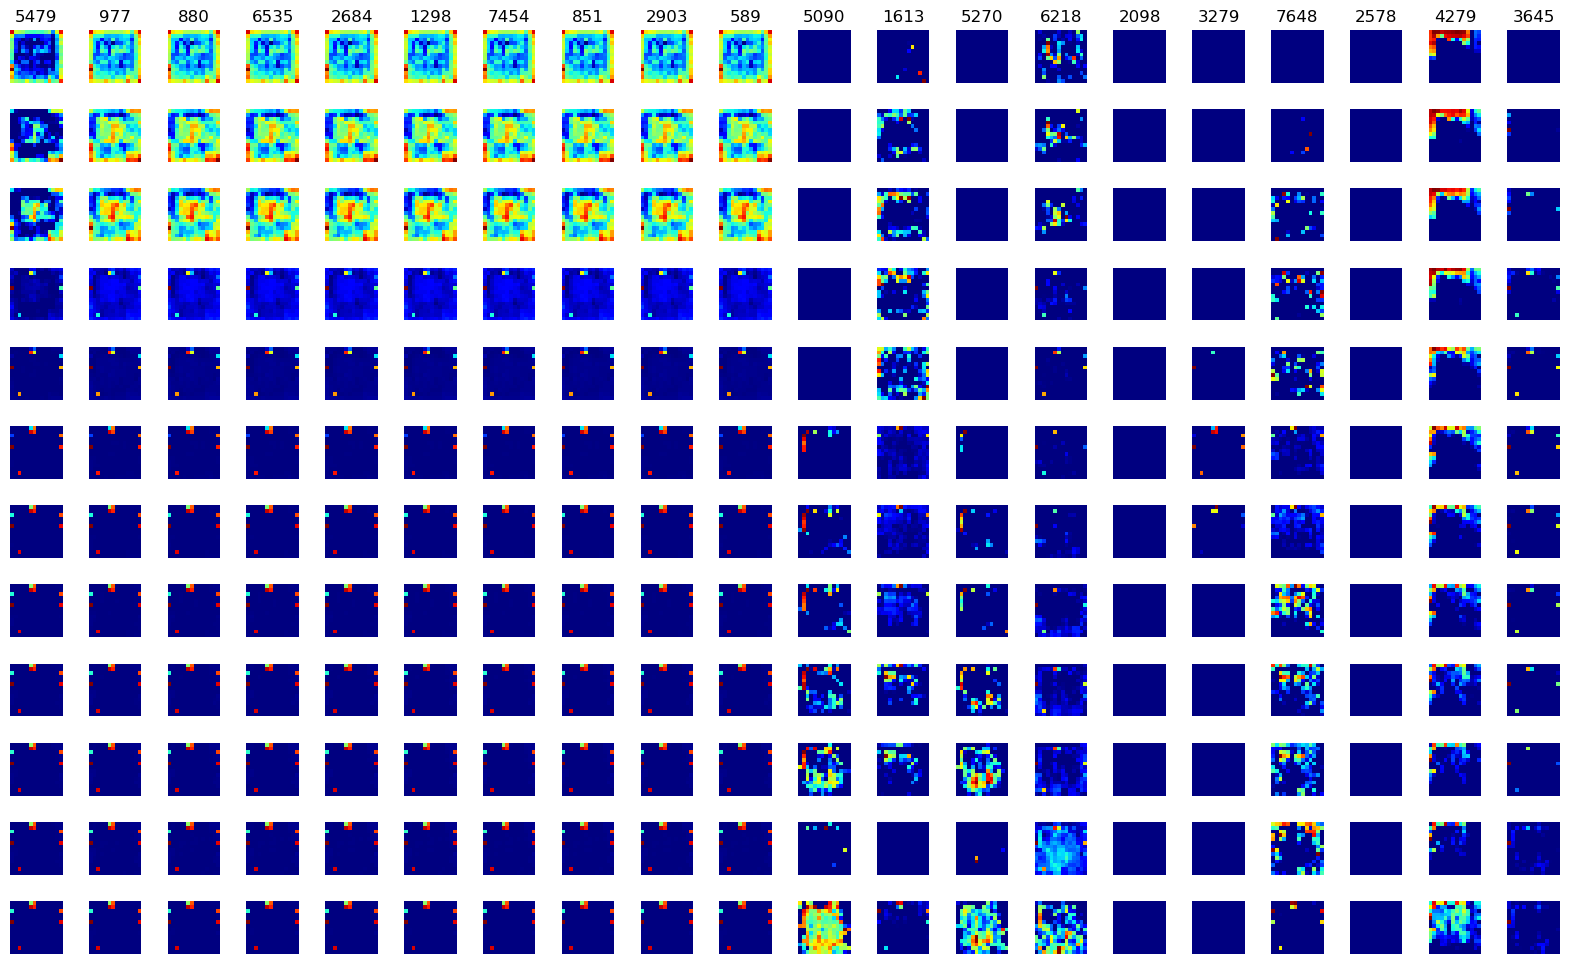

In [35]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = low_20_z_avg[j]
        sns.heatmap(activation[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


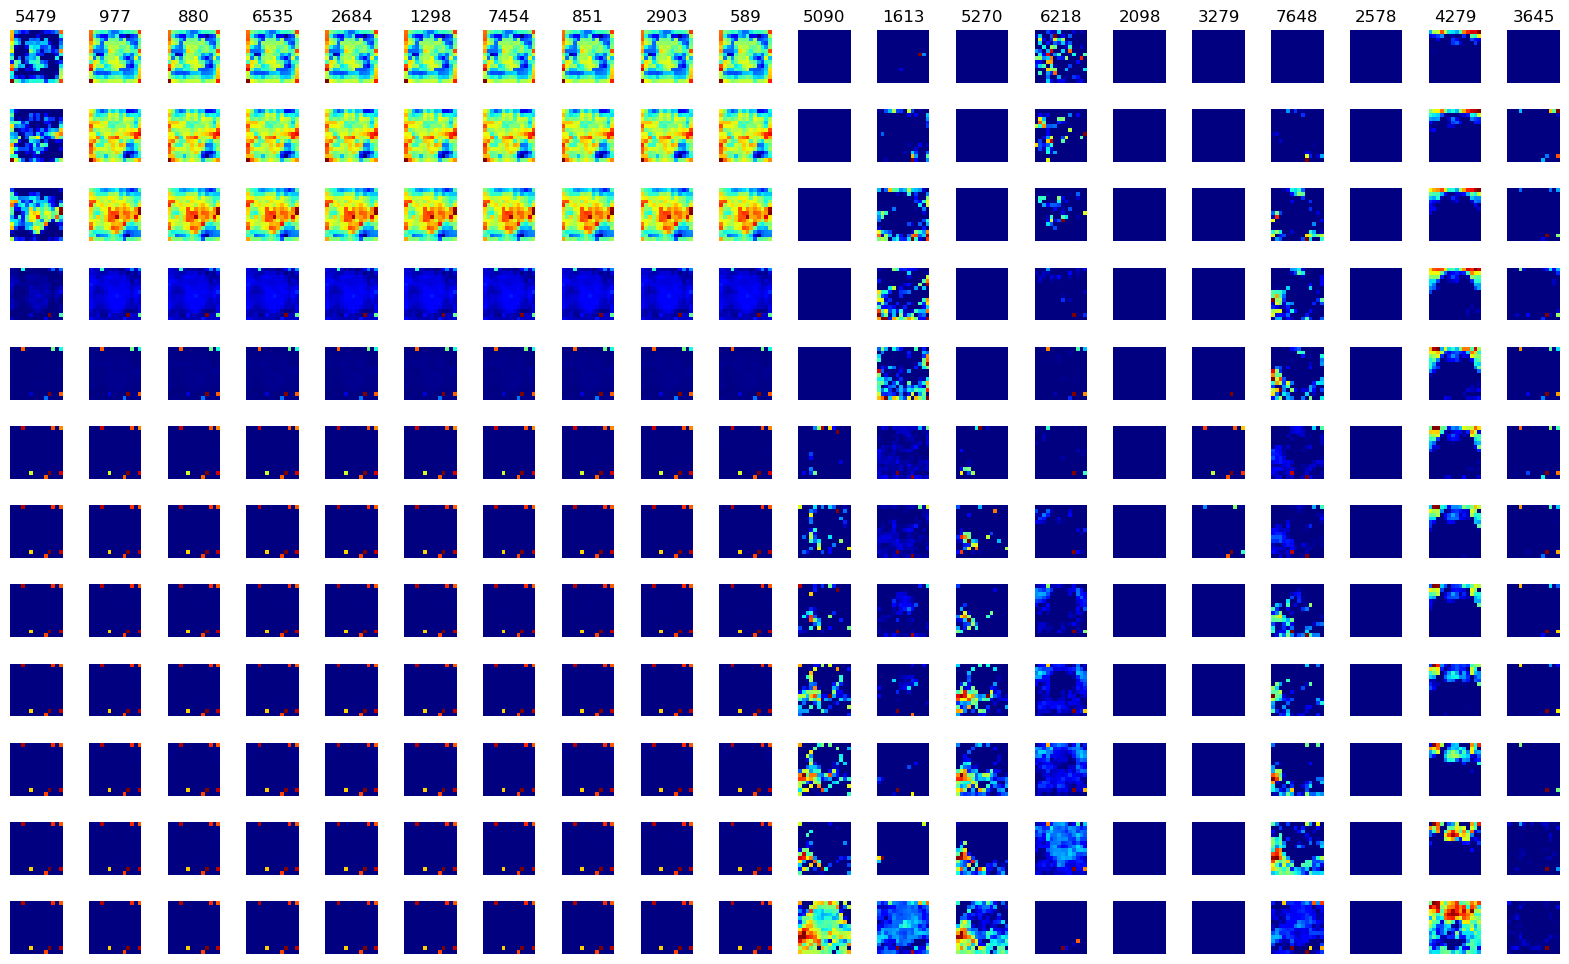

In [36]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = low_20_z_avg[j]
        sns.heatmap(activation2[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


# untied SAE

In [79]:
encoder = torch.randn((7680, 768), device = device) # encoder
decoder = torch.randn((768, 7680), device = device) # decoder
nn.init.xavier_uniform_(encoder)
nn.init.xavier_uniform_(decoder)
encoder_bias = torch.zeros(7680, device = device) # encoder bias

# load trained SAE
untied_sae = UntiedSAE(encoder, decoder, encoder_bias)
untied_sae.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_untied.pth'))
untied_sae.to_device(device)

<Axes: >

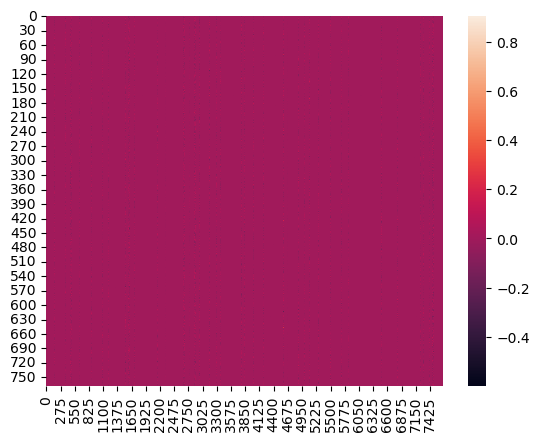

In [80]:
sns.heatmap(untied_sae.get_learned_dict().cpu().detach().numpy())

In [81]:
untied_sae.get_learned_dict().shape

torch.Size([768, 7680])

(array([6.711e+03, 2.000e+01, 3.200e+01, 9.000e+00, 6.000e+00, 5.000e+00,
        6.000e+00, 1.900e+01, 2.400e+01, 5.200e+01, 1.280e+02, 1.910e+02,
        1.470e+02, 1.120e+02, 6.700e+01, 4.200e+01, 1.700e+01, 1.900e+01,
        1.400e+01, 1.100e+01, 5.000e+00, 6.000e+00, 2.000e+00, 0.000e+00,
        5.000e+00, 1.000e+00, 3.000e+00, 4.000e+00, 0.000e+00, 1.000e+00,
        3.000e+00, 1.000e+00, 2.000e+00, 1.000e+00, 2.000e+00, 0.000e+00,
        4.000e+00, 0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 2.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 1.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+0

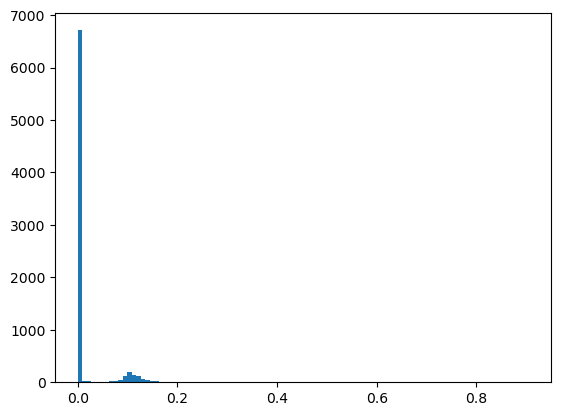

In [82]:
# decoder max weight histogram
u_max_absolute_activation = []
for i in range(7680):
    weight = untied_sae.get_learned_dict().cpu().detach().numpy()[:,i]
    weight = np.abs(weight)
    u_max_absolute_activation.append(max(weight))

u_top_20_indices = np.argsort(u_max_absolute_activation)[-20:]
u_top_20_indices = u_top_20_indices[::-1]

plt.hist(u_max_absolute_activation, bins=100)

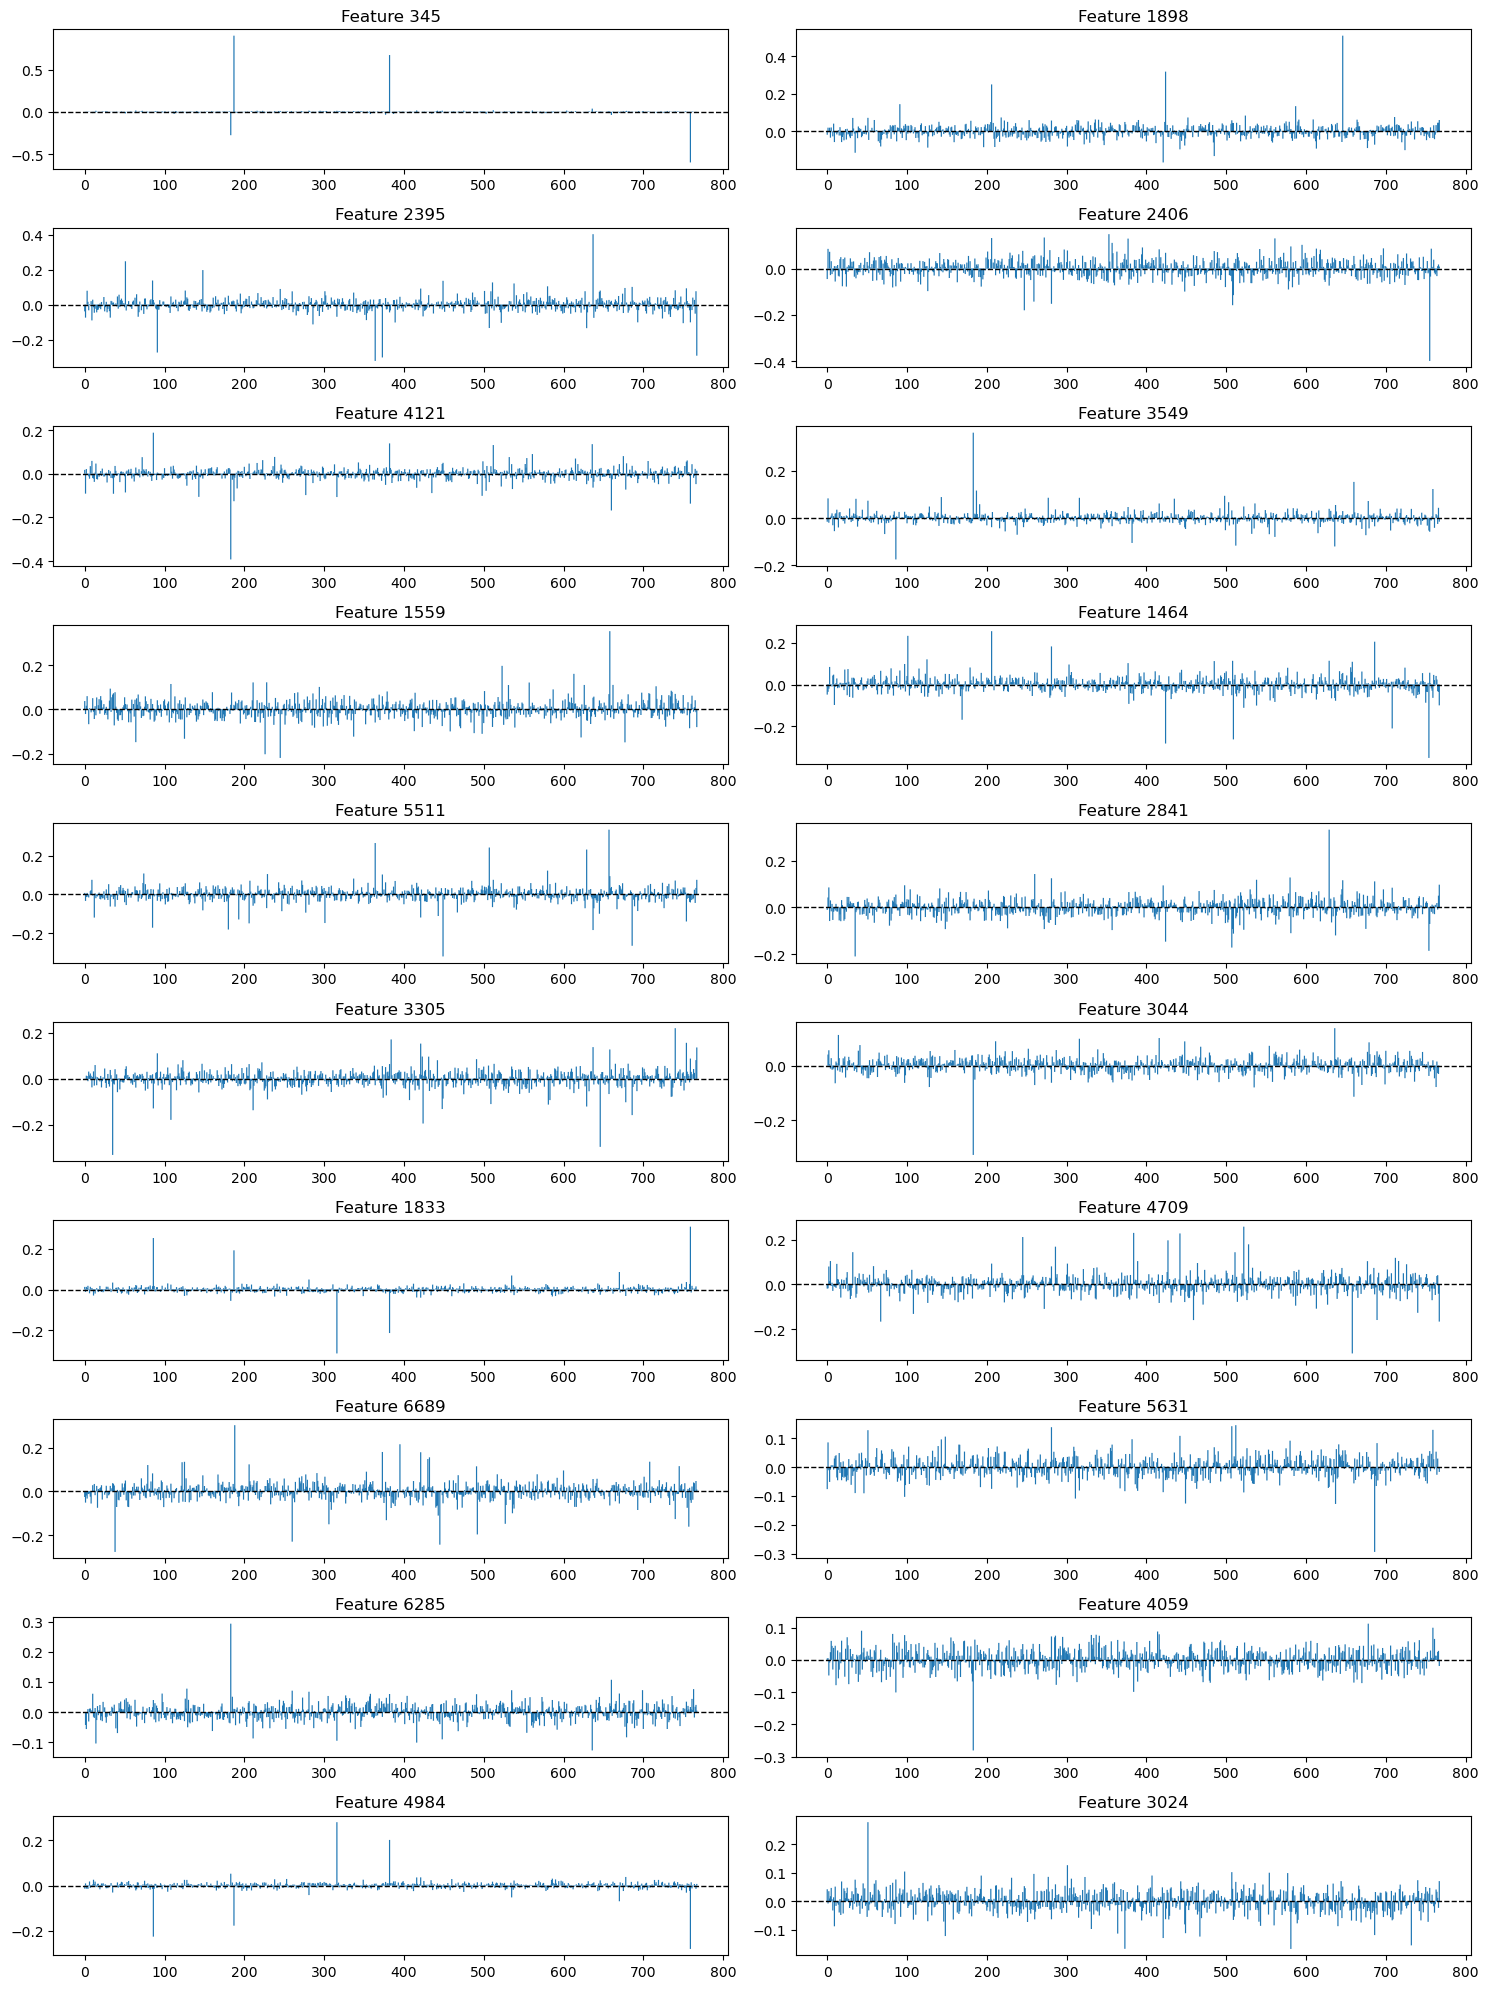

In [83]:
# top 20 max absolute activation decoder
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.get_learned_dict().cpu().detach().numpy()[:,u_top_20_indices[i]]# decoder weights
    ax.bar(range(len(act)), act, snap=False, width=1.5)
    ax.set_title(f"Feature {u_top_20_indices[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



(array([  4.,  13.,  43.,  64., 101.,  91.,  82.,  66.,  64.,  42.,  32.,
         45.,  25.,  17.,  17.,  13.,   9.,   6.,   6.,   6.,   5.,   2.,
          2.,   1.,   3.,   2.,   0.,   0.,   0.,   0.,   2.,   1.,   1.,
          1.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,
          1.]),
 array([0.14327767, 0.16659909, 0.1899205 , 0.21324192, 0.23656334,
        0.25988474, 0.28320616, 0.30652758, 0.329849  , 0.35317042,
        0.37649184, 0.39981326, 0.42313465, 0.44645607, 0.46977749,
        0.49309891, 0.5164203 , 0.53974175, 0.56306314, 0.58638459,
        0.60970598, 0.63302743, 0.65634882, 0.

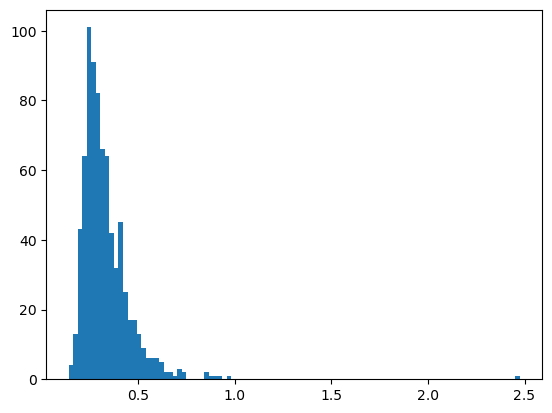

In [85]:
#max encoder activation
max_e_absolute_activation = []
for i in range(768):   
    weight = untied_sae.encoder.cpu().detach().numpy()[:,i]
    weight = np.abs(weight)
    max_e_absolute_activation.append(max(weight))


ue_top_10_indices = np.argsort(max_e_absolute_activation)[-10:]
ue_top_10_indices = ue_top_10_indices[::-1]

plt.hist(max_e_absolute_activation, bins=100)


<BarContainer object of 768 artists>

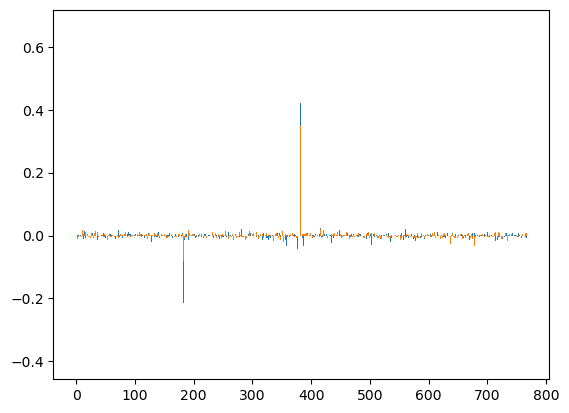

In [86]:
plt.bar(range(768),untied_sae.decoder.cpu().detach().numpy()[:,345])
plt.bar(range(768), untied_sae.encoder.cpu().detach().numpy()[345,:])

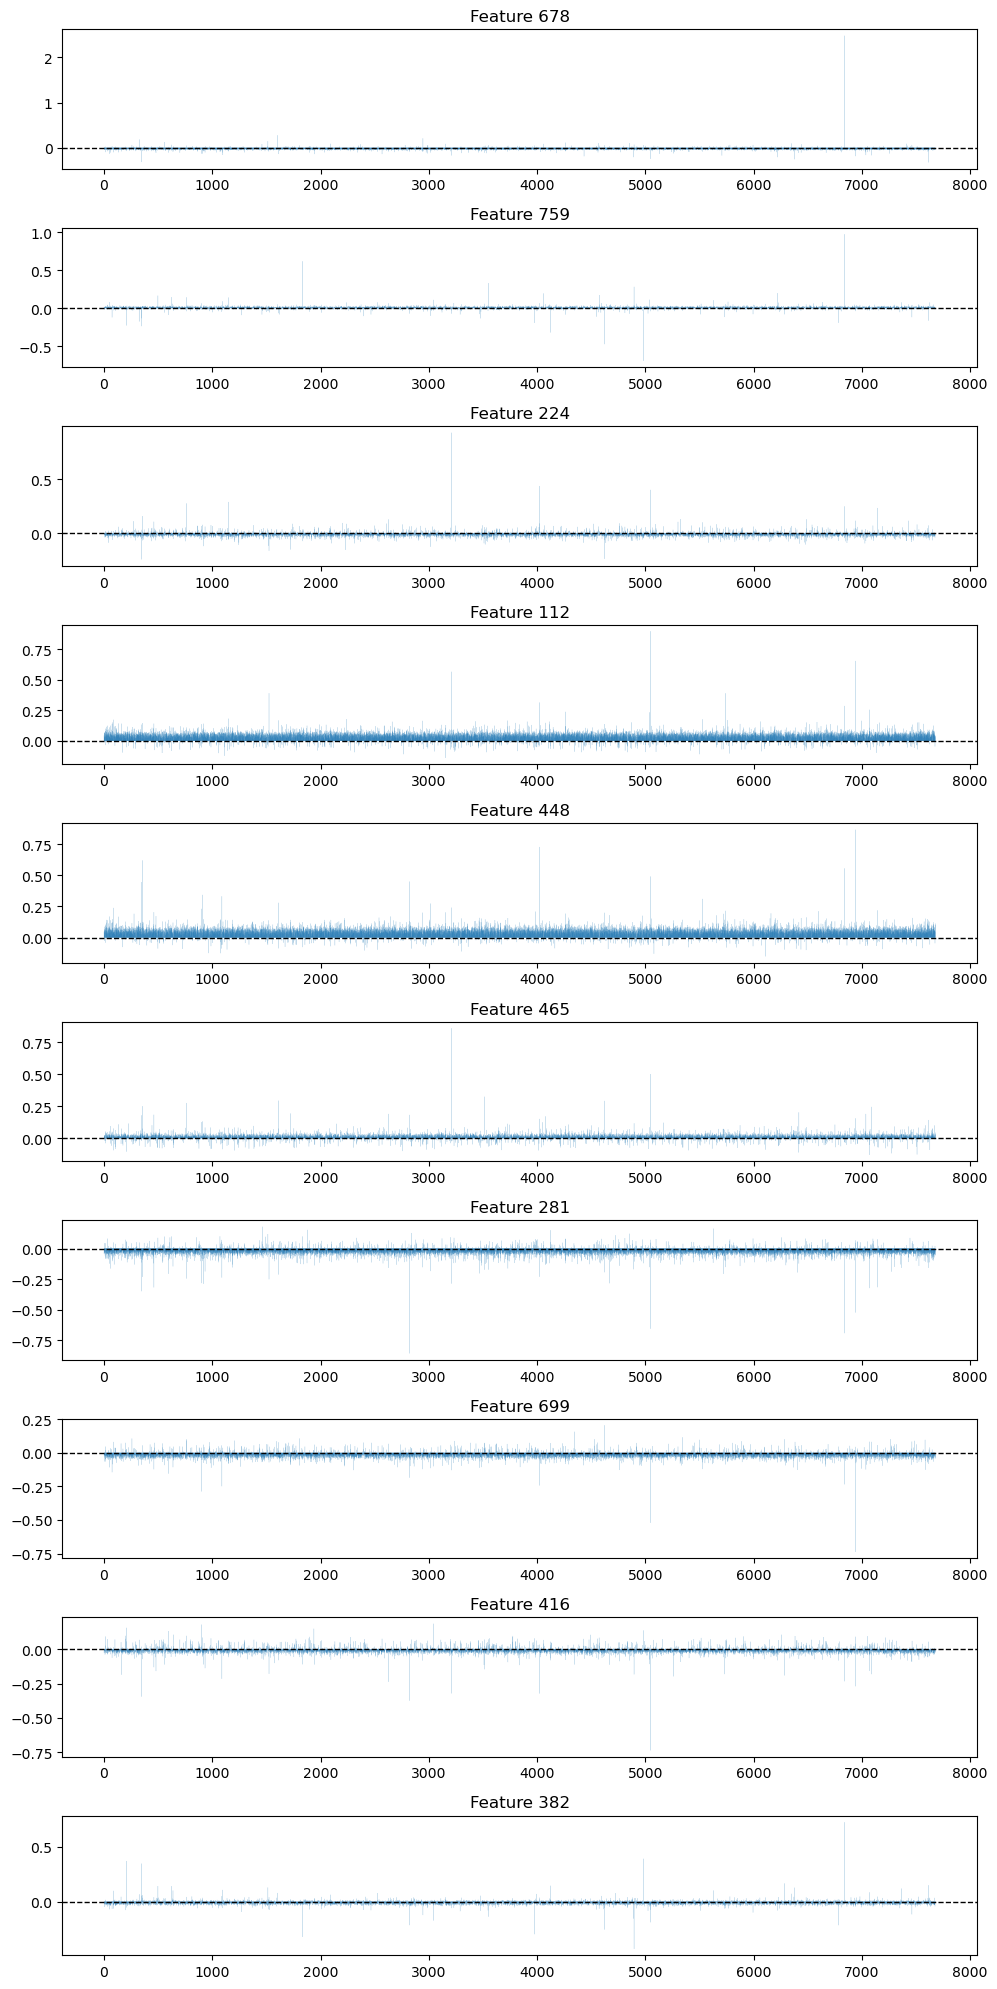

In [87]:
#top 10 max absolute encoder activation
fig, axes = plt.subplots(10, 1, figsize=(10, 20))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.encoder.cpu().detach().numpy()[:,ue_top_10_indices[i]]# encoder weights
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {ue_top_10_indices[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()

In [88]:
# compute max absolute z score across features
z = []
for i in range(7680):
    weight = untied_sae.get_learned_dict().cpu().detach().numpy()[:,i] #decoder weight
    m = np.mean(untied_sae.get_learned_dict().cpu().detach().numpy(),axis=0)
    s = np.std(untied_sae.get_learned_dict().cpu().detach().numpy(),axis=0)
    z.append((weight-m)/s)

max_z = []
for i in range(7680):
    abs_z = np.abs(z[i])
    max_z.append(max(abs_z))

u_top_20_z = np.argsort(max_z)[-20:]
u_top_20_z = u_top_20_z[::-1]

u_top_50_z = np.argsort(max_z)[-50:]
u_top_50_z = u_top_50_z[::-1]

In [89]:
u_top_20_z

array([ 352, 6321, 6803, 2035, 6560, 5626, 1030, 2655, 4083, 6097,  394,
       2167, 4371,  344, 5074, 3140, 6103, 2875,   73, 7546])

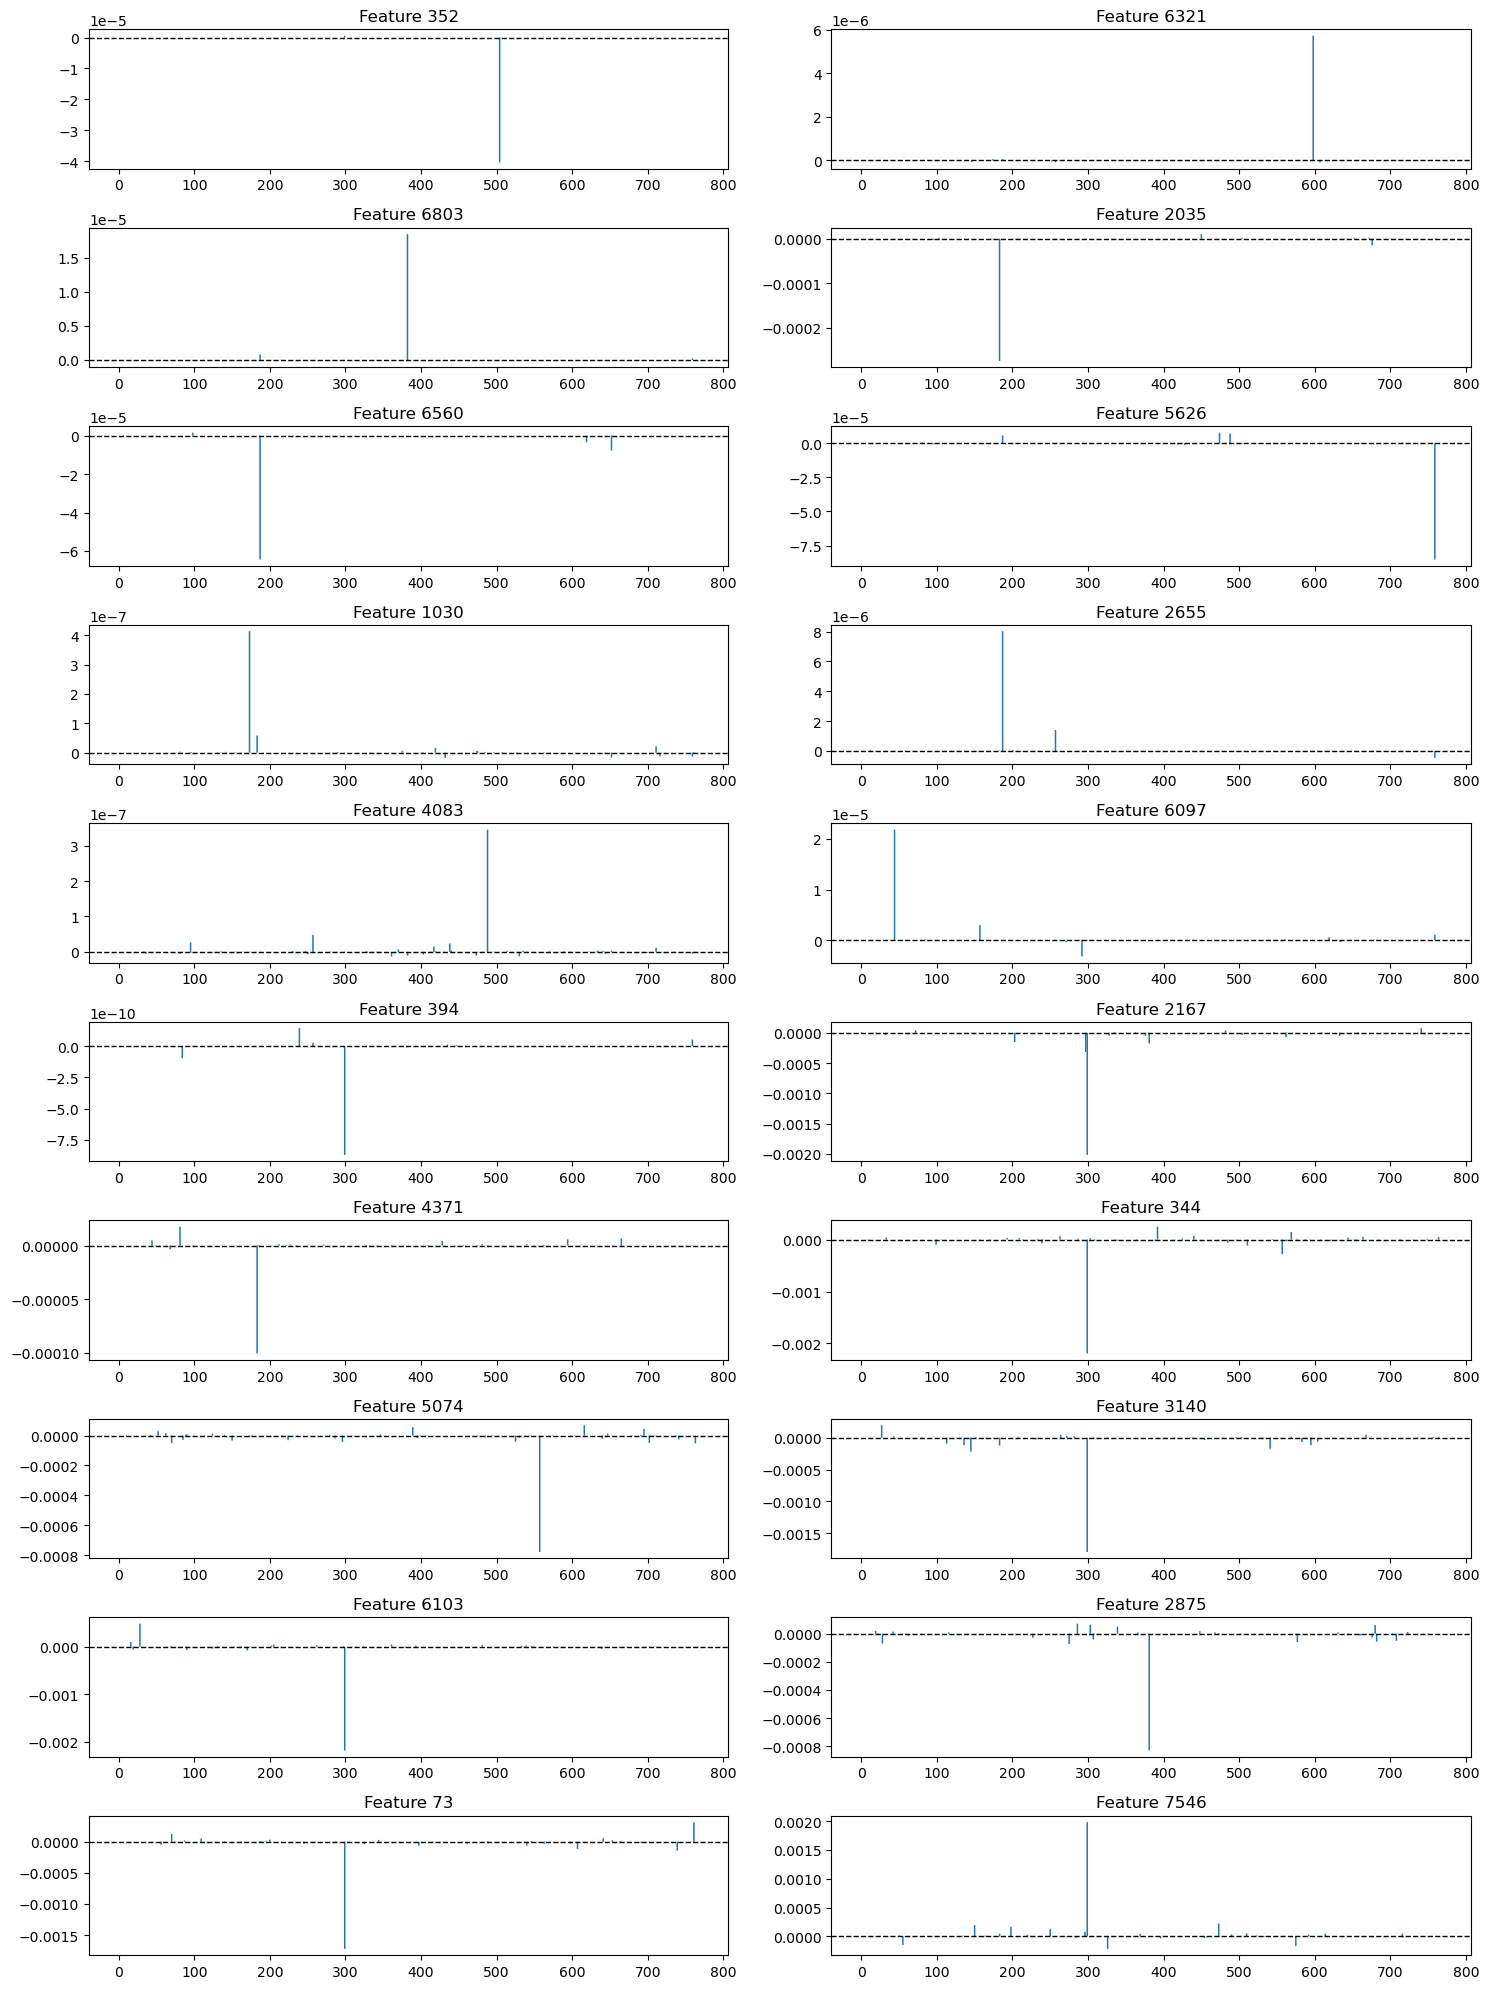

In [90]:
# top 20 max absolute z score 
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.get_learned_dict().cpu().detach().numpy()[:,u_top_20_z[i]]# decoder weights
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {u_top_20_z[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)
    
plt.tight_layout()
plt.show()



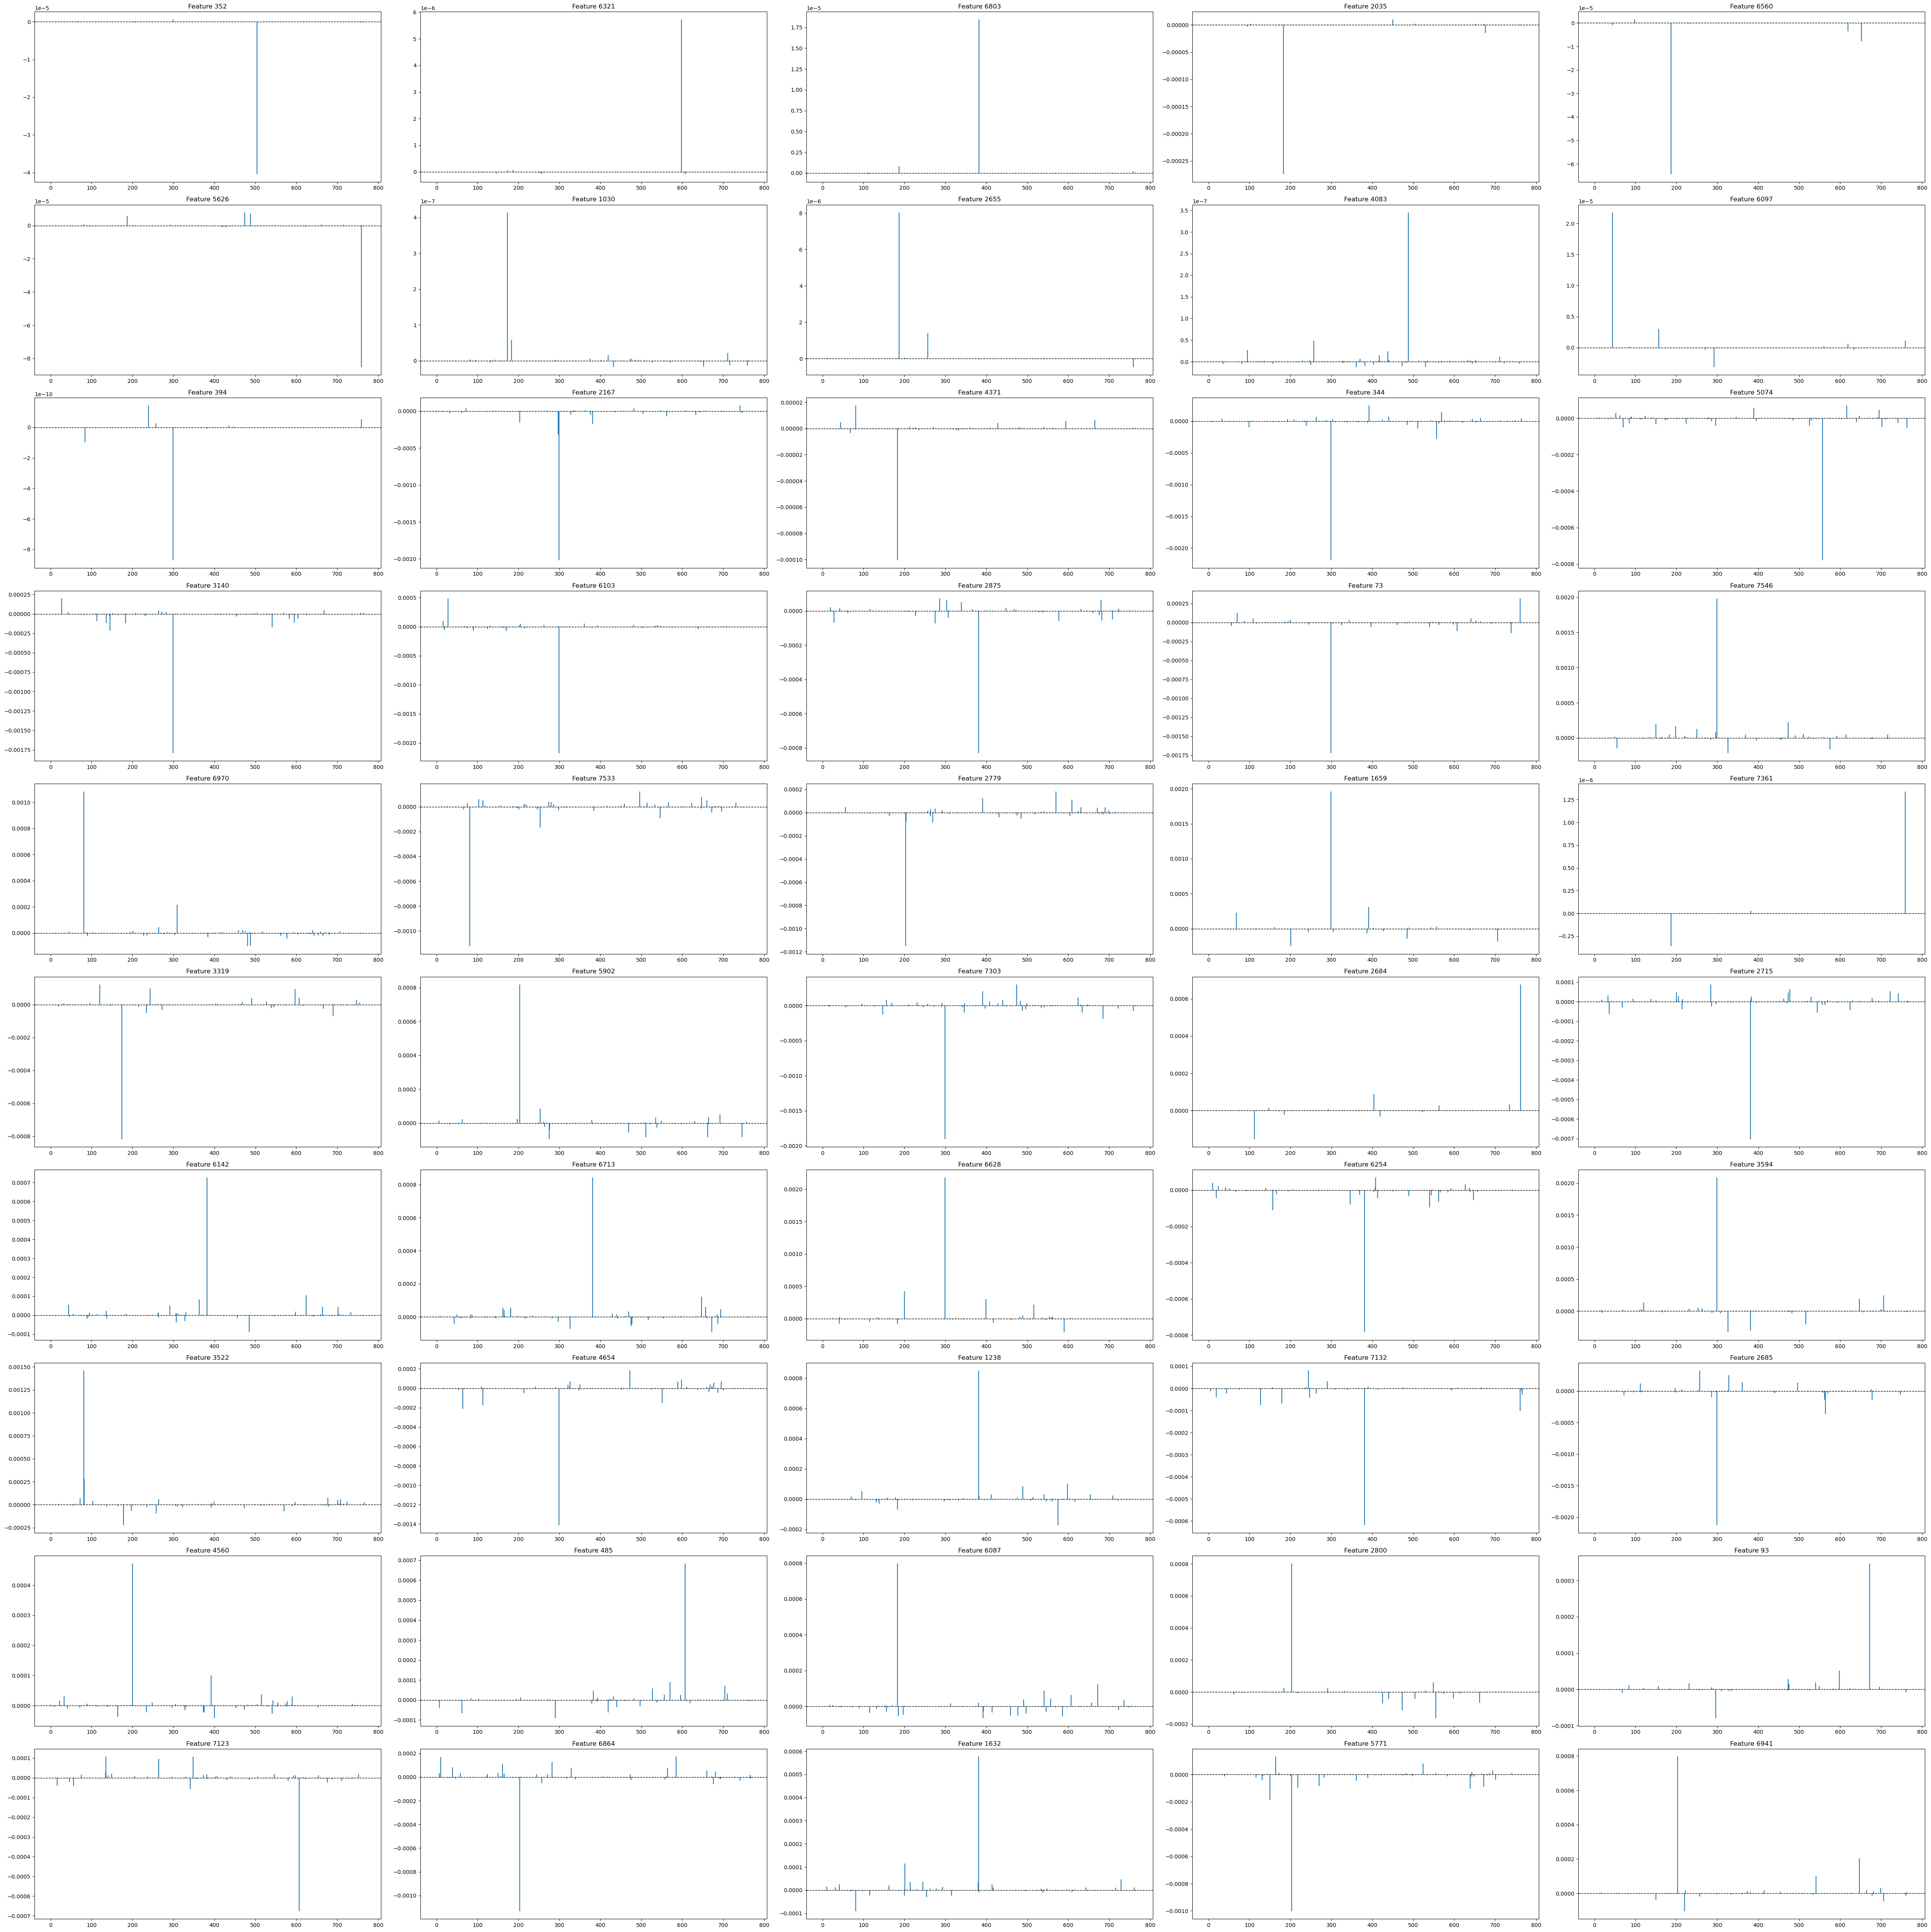

In [91]:
fig, axes = plt.subplots(10, 5, figsize=(50, 50))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.get_learned_dict().cpu().detach().numpy()[:,u_top_50_z[i]]# decoder weights
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {u_top_50_z[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



In [92]:
# compare average z scores
avg_z = []
for i in range(7680):
    abs_z = np.abs(z[i])
    avg_z.append(abs_z.mean())

u_top_20_z_avg = np.argsort(avg_z)[-20:]
u_top_20_z_avg = u_top_20_z_avg[::-1]

u_low_20_z_avg = np.argsort(avg_z)[:20]

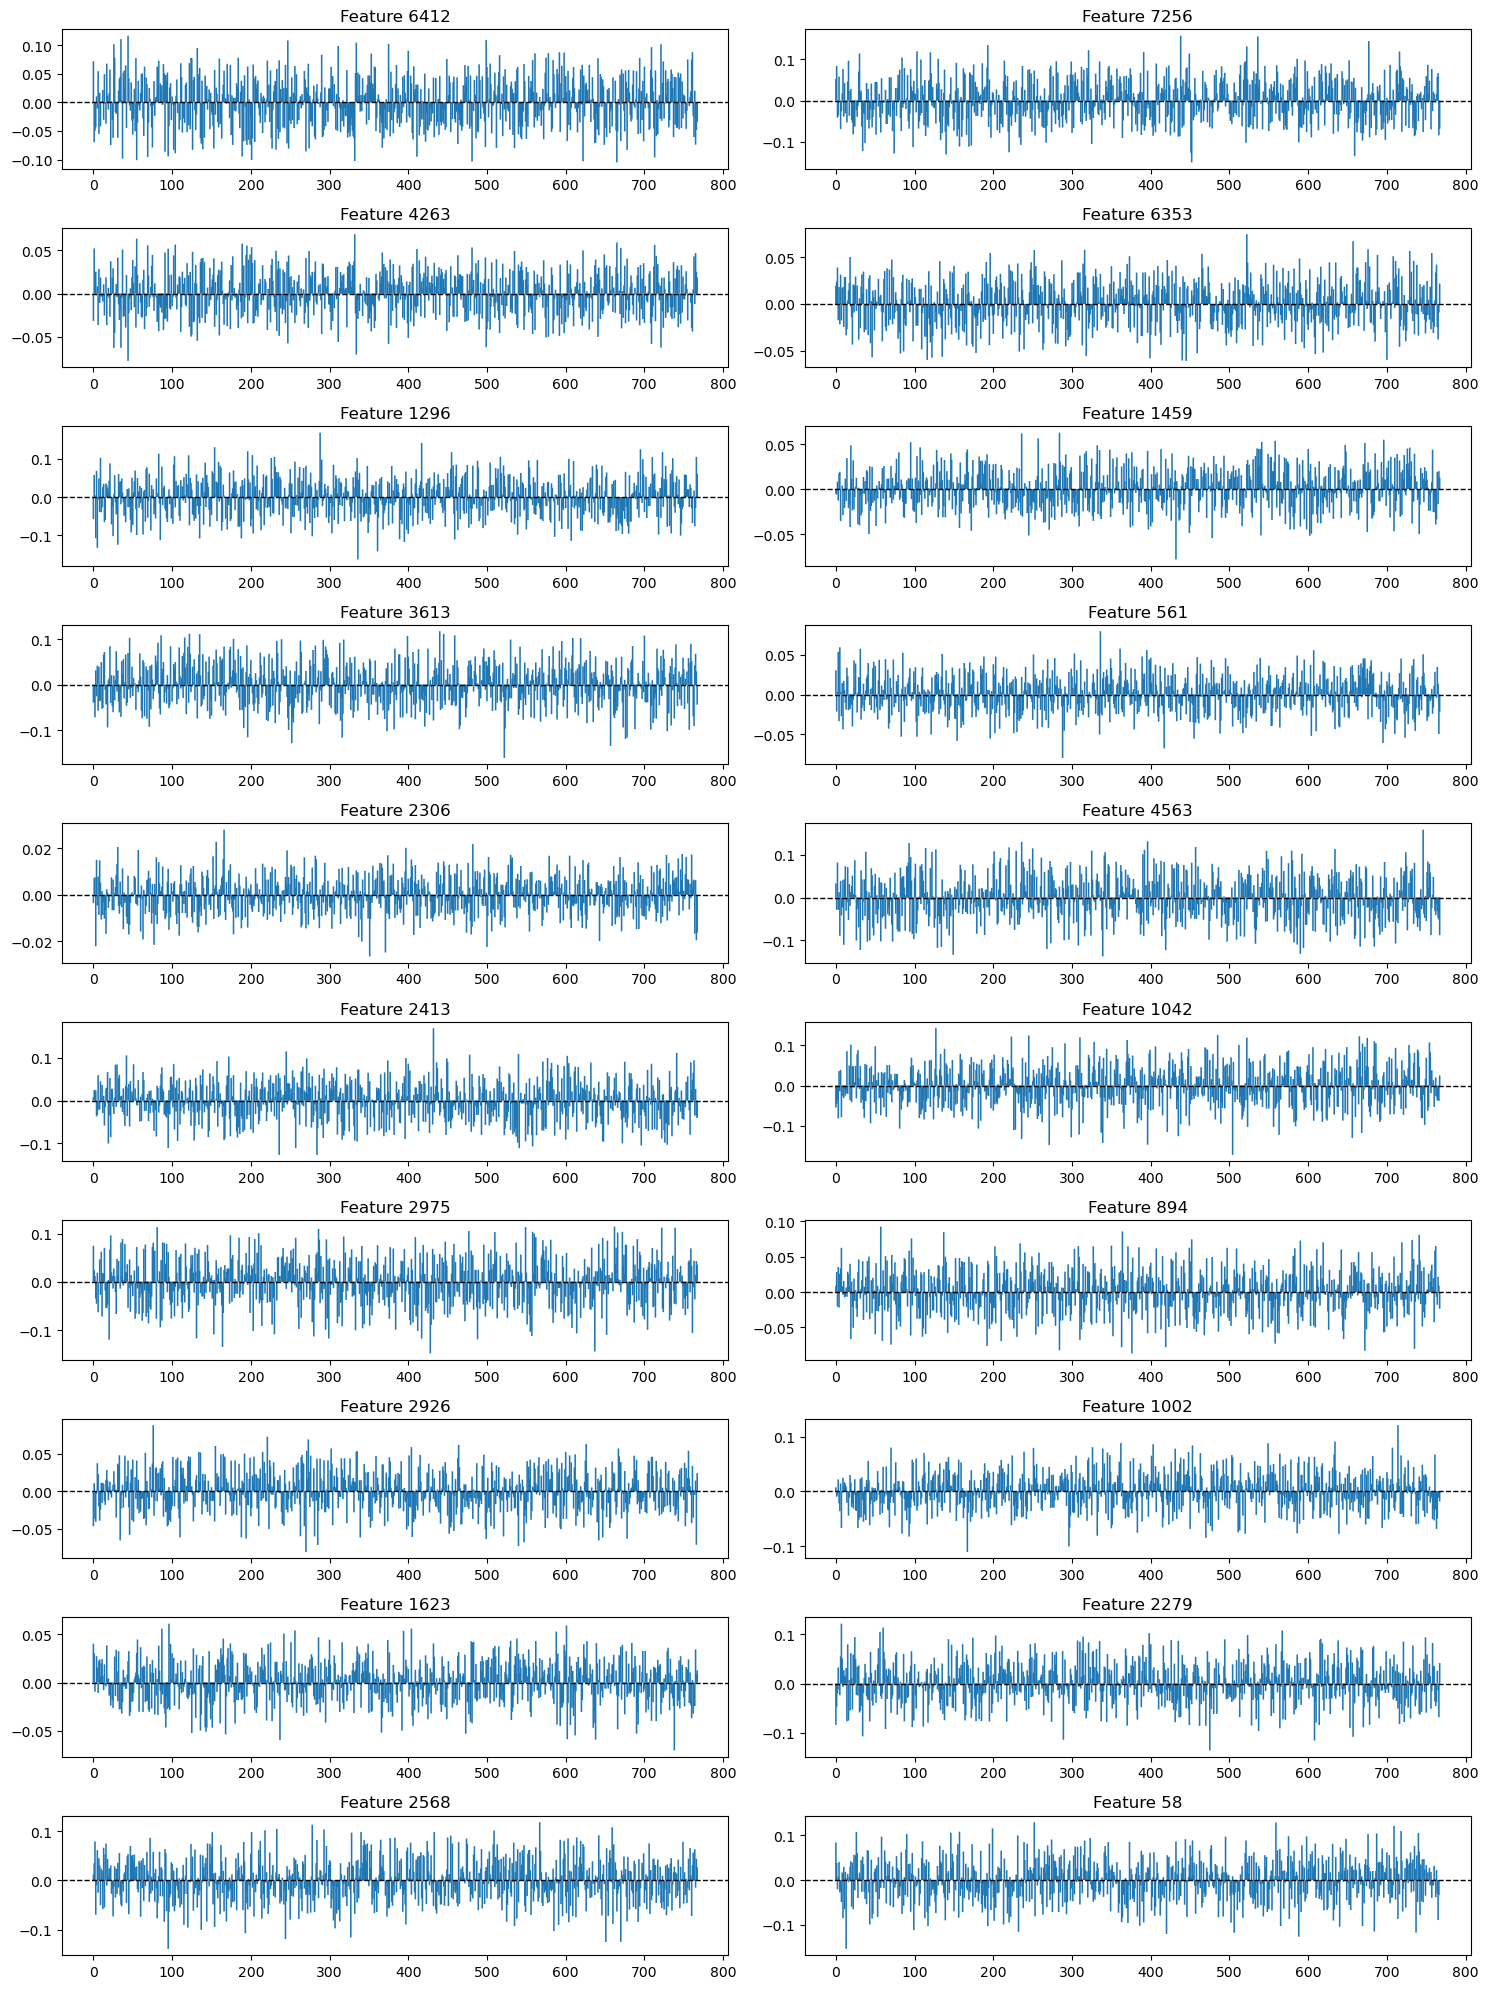

In [93]:
# top 20 average z score
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.get_learned_dict().cpu().detach().numpy()[:,u_top_20_z_avg[i]]# decoder weights
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {u_top_20_z_avg[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



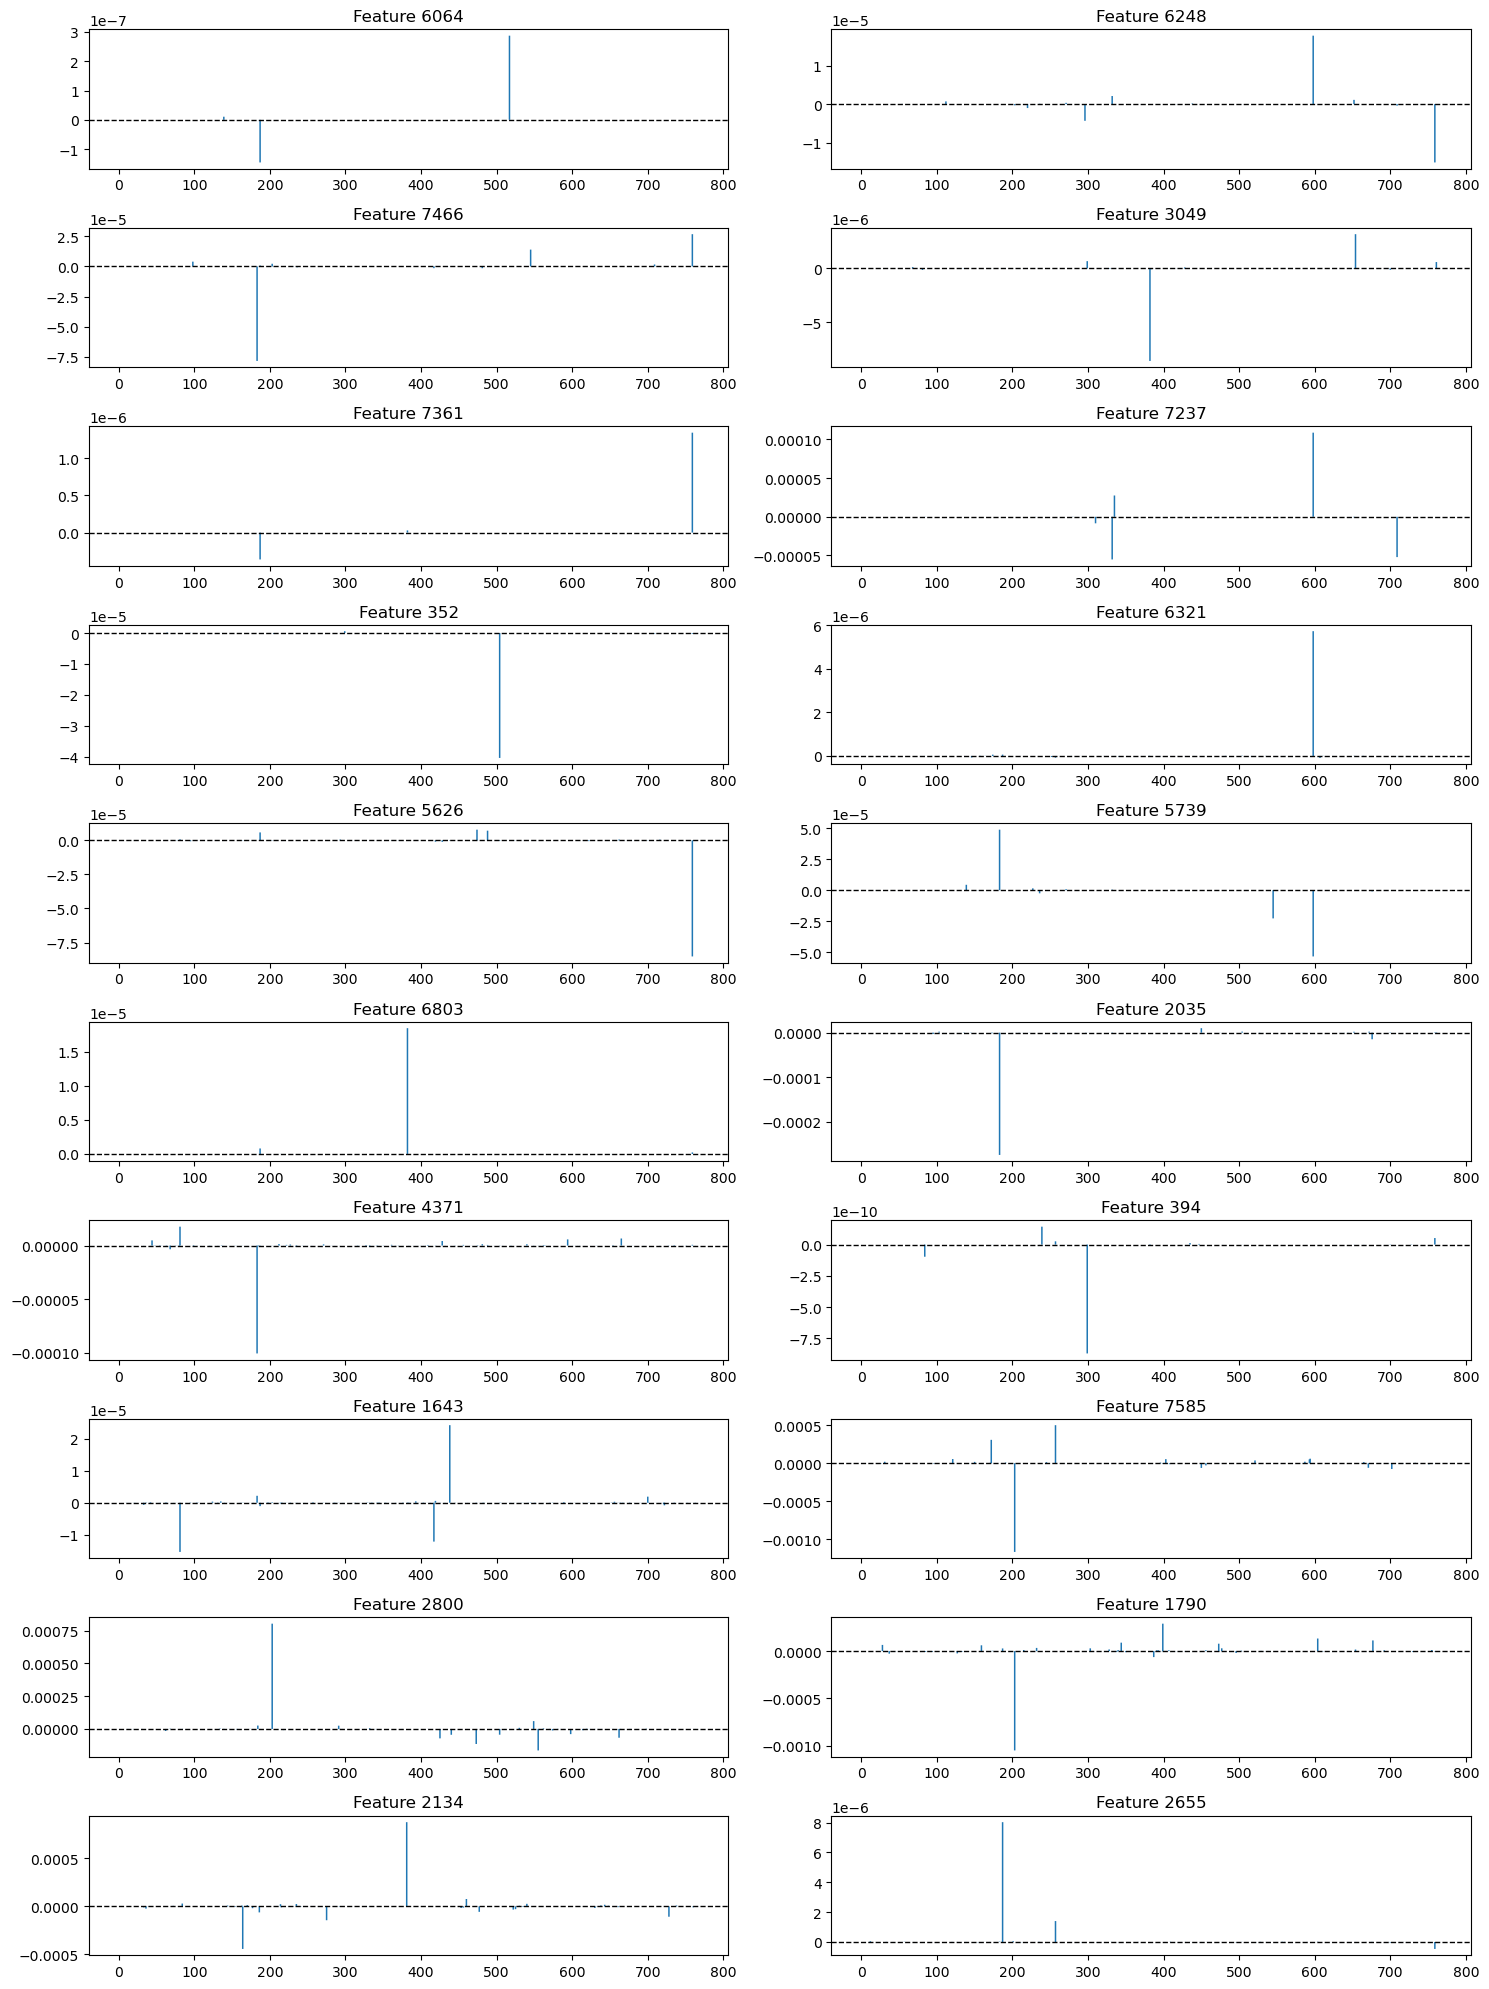

In [94]:
# bottom 20 average z scores
fig, axes = plt.subplots(10, 2, figsize=(15, 20))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.get_learned_dict().cpu().detach().numpy()[:,u_low_20_z_avg[i]]# decoder weights
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {u_low_20_z_avg[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



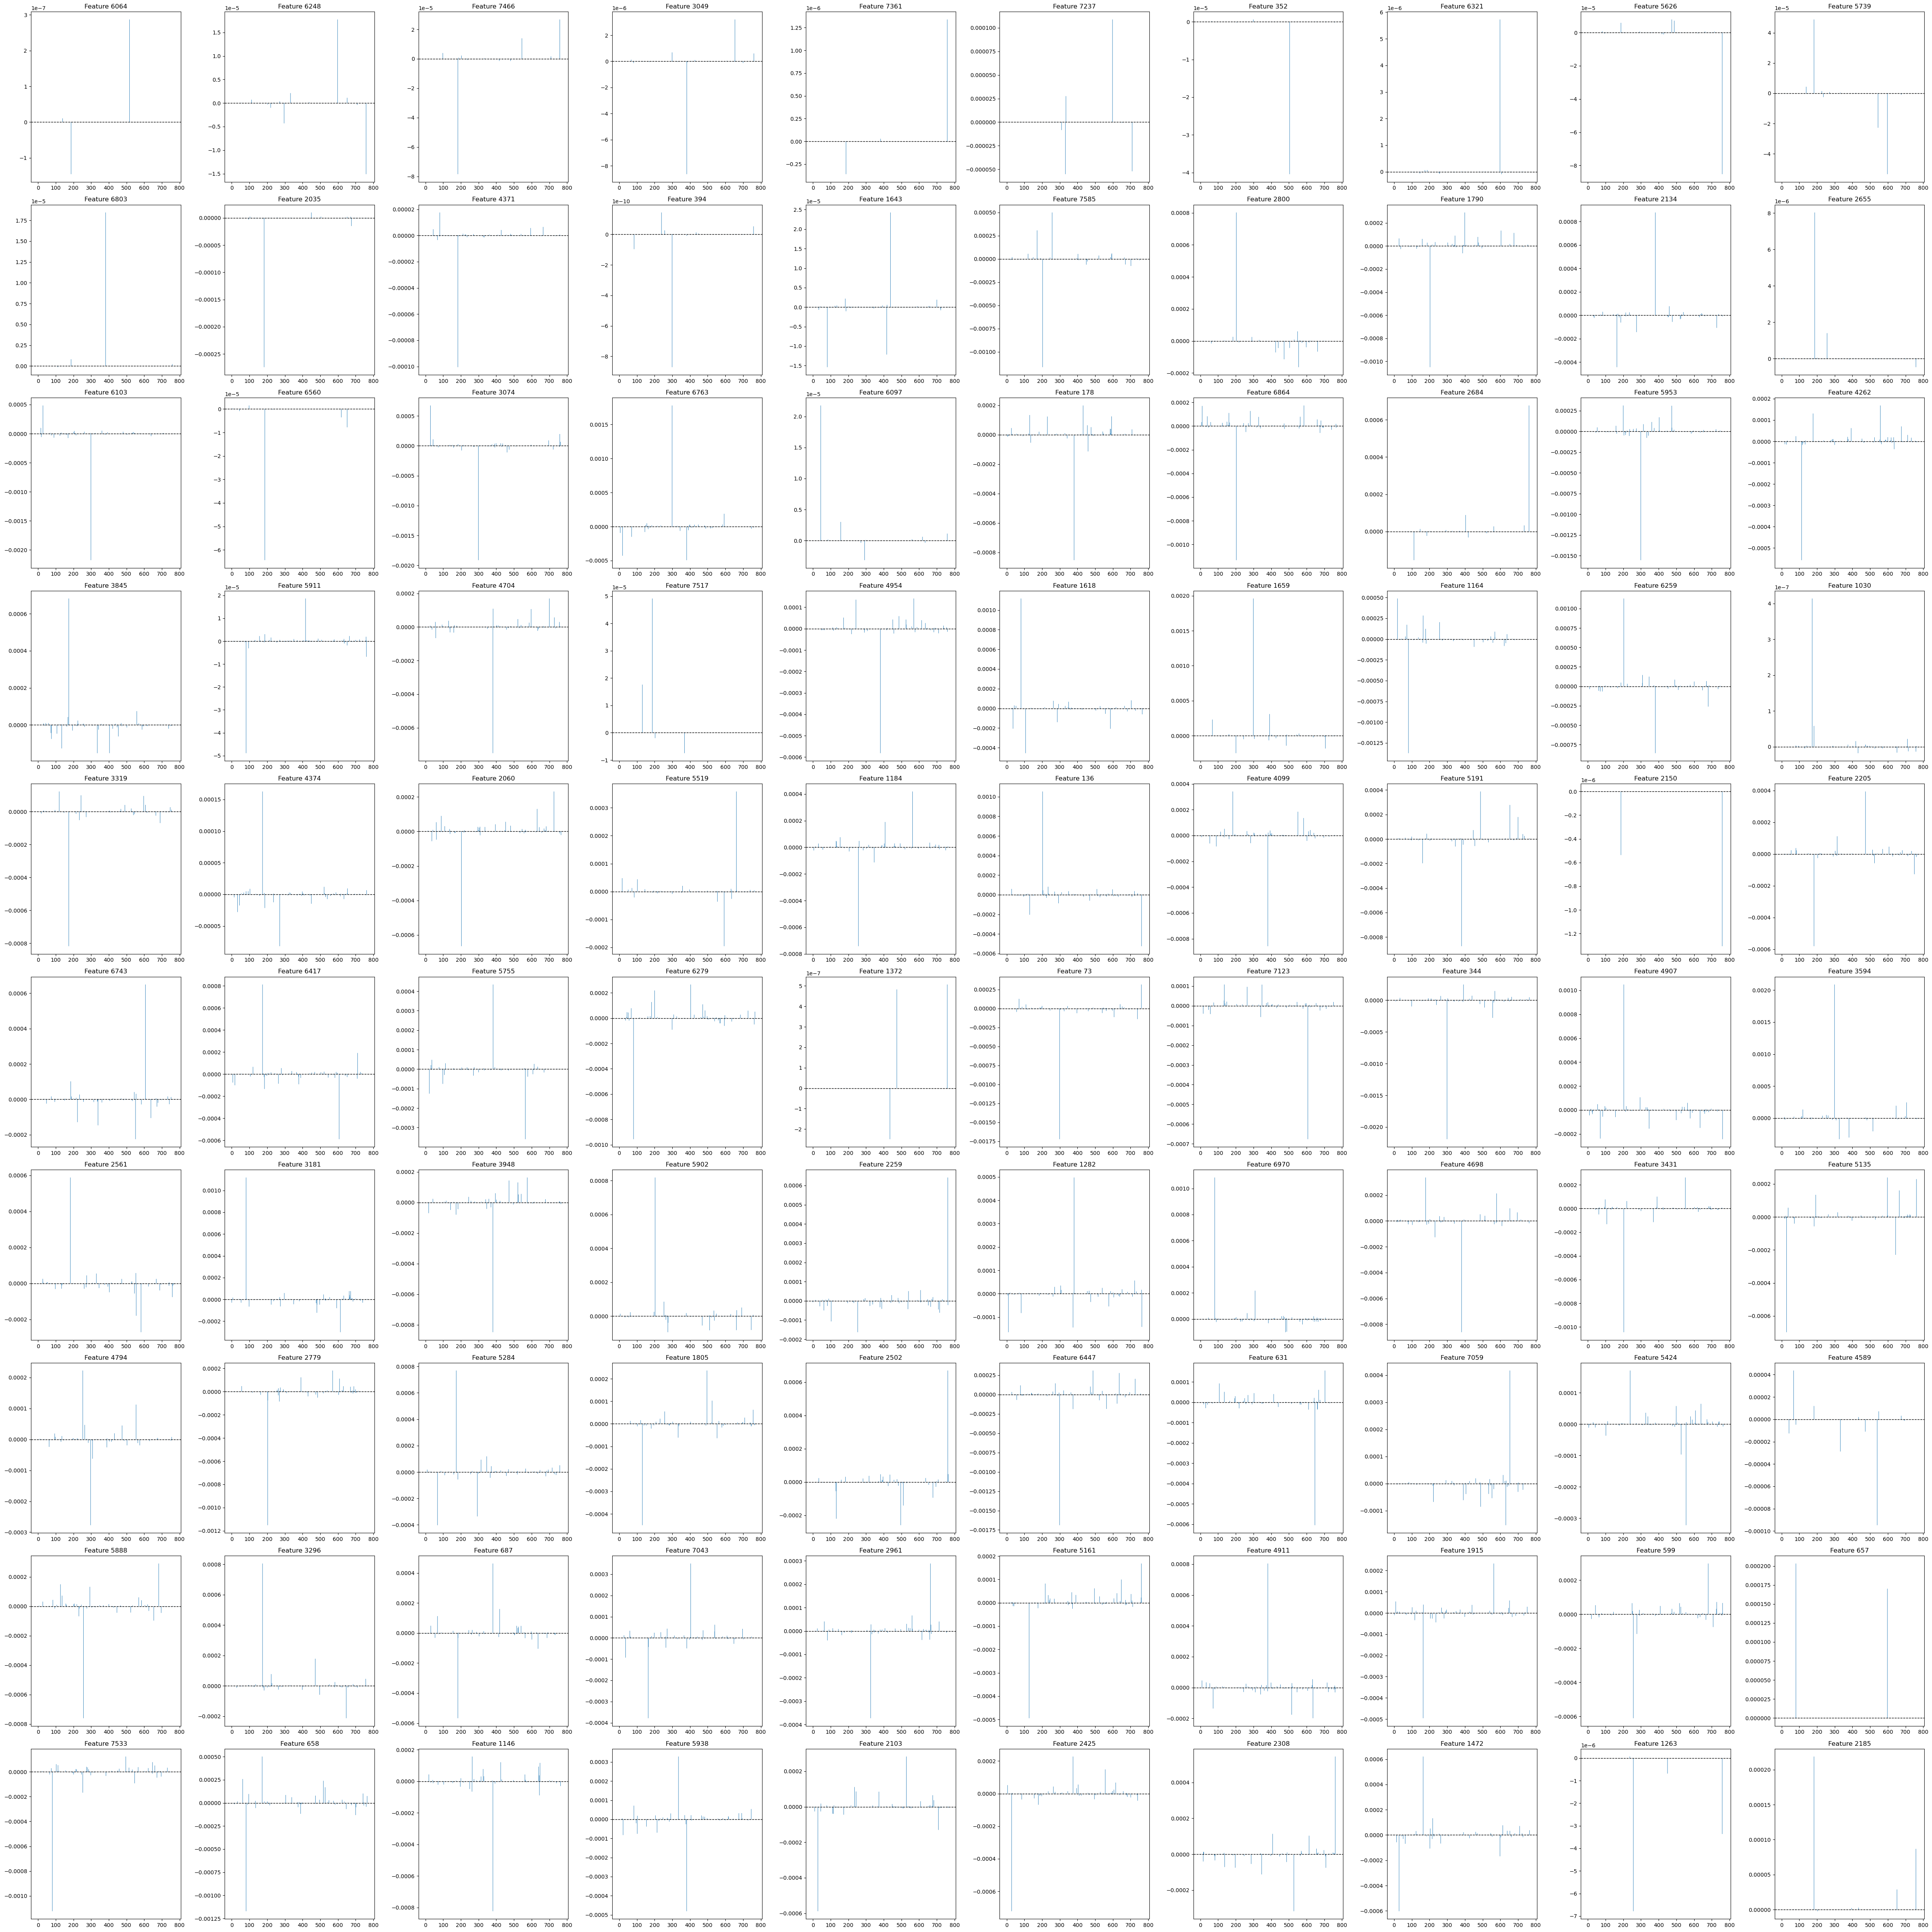

In [95]:
# bottom 100 average z scores
u_low_100_z_avg = np.argsort(avg_z)[:100]

fig, axes = plt.subplots(10, 10, figsize=(50, 50))

for i, ax in enumerate(axes.flatten()):
    act = untied_sae.get_learned_dict().cpu().detach().numpy()[:,u_low_100_z_avg[i]]# decoder weights
    ax.bar(range(len(act)), act, snap=False, width=2)
    ax.set_title(f"Feature {u_low_100_z_avg[i]}")
    ax.axhline(y=0, color='black', linestyle='--', linewidth=1)

plt.tight_layout()
plt.show()



In [96]:
untied_activation = []
for i in range(12):
    untied_activation.append(untied_sae.encode(activation_inputs[i].to(device)).squeeze(0))

untied_activation2 = []
for i in range(12):
    untied_activation2.append(untied_sae.encode(activation_inputs2[i].to(device)).squeeze(0))

## top 20 absolute activation

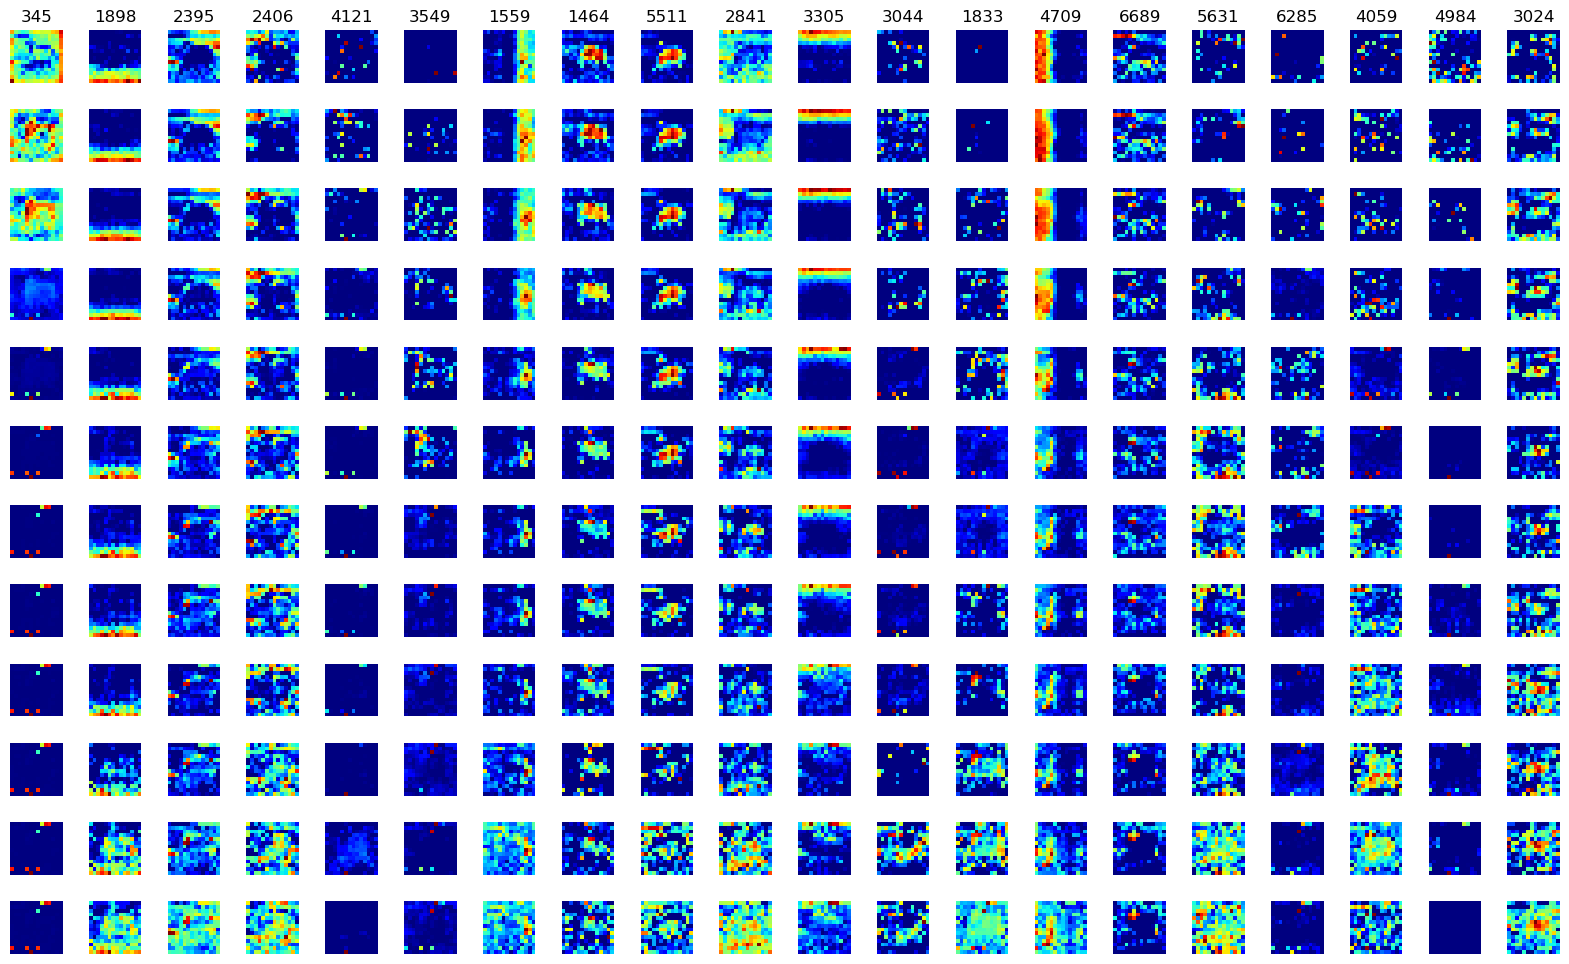

In [97]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = u_top_20_indices[j]
        sns.heatmap(untied_activation[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


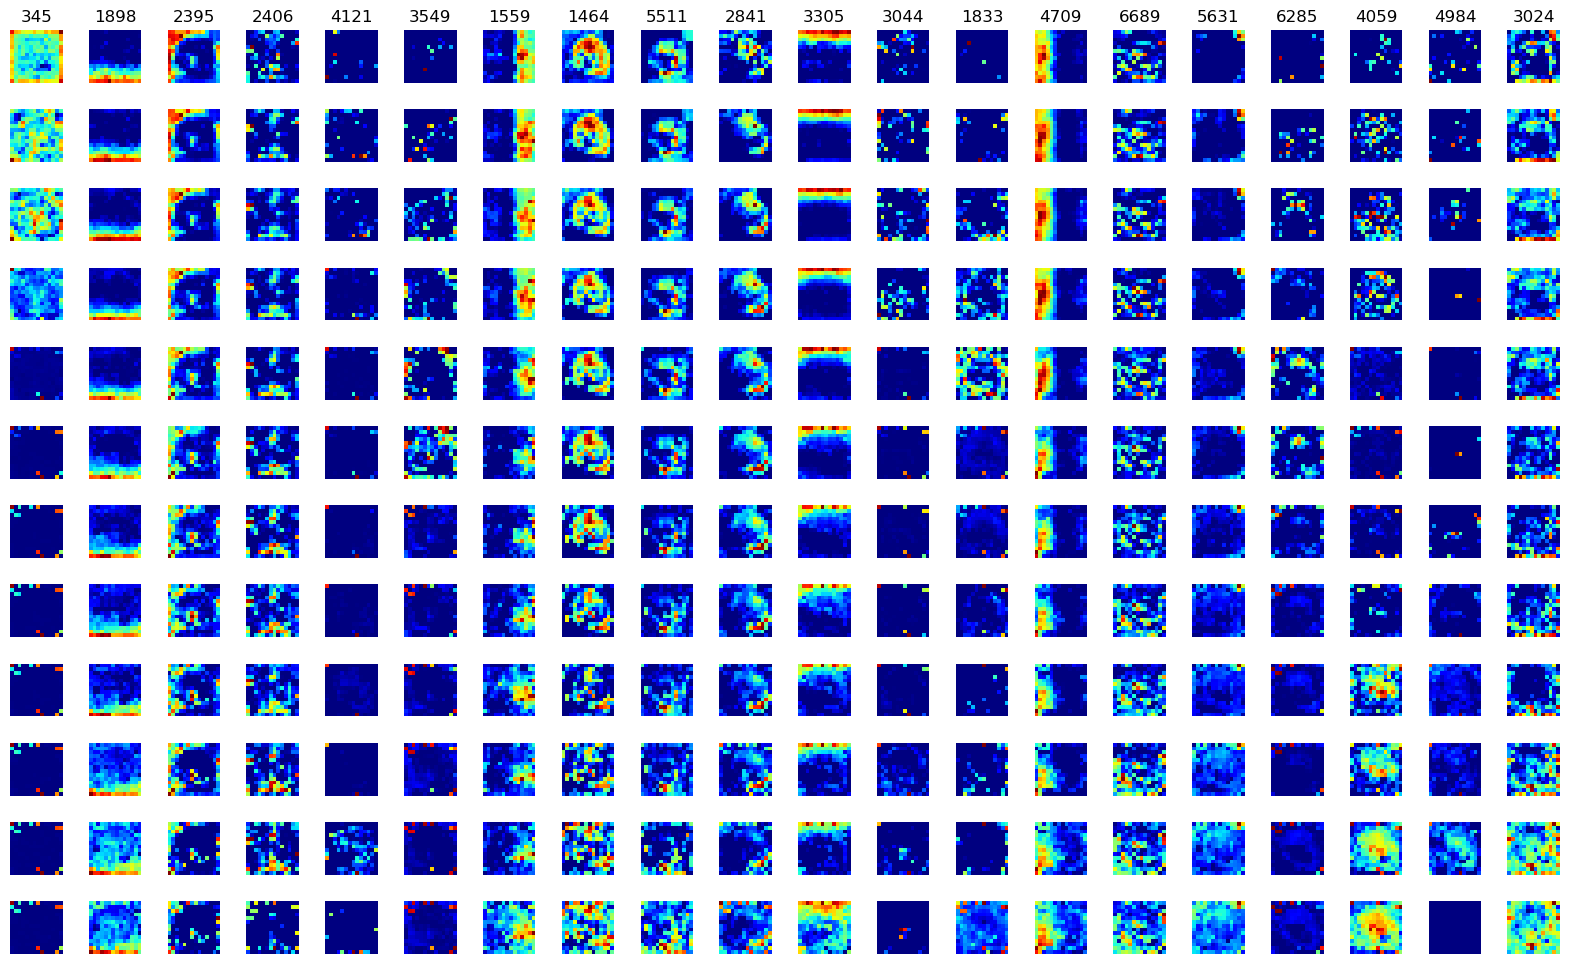

In [98]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = u_top_20_indices[j]
        sns.heatmap(untied_activation2[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


## top 20 average z scores

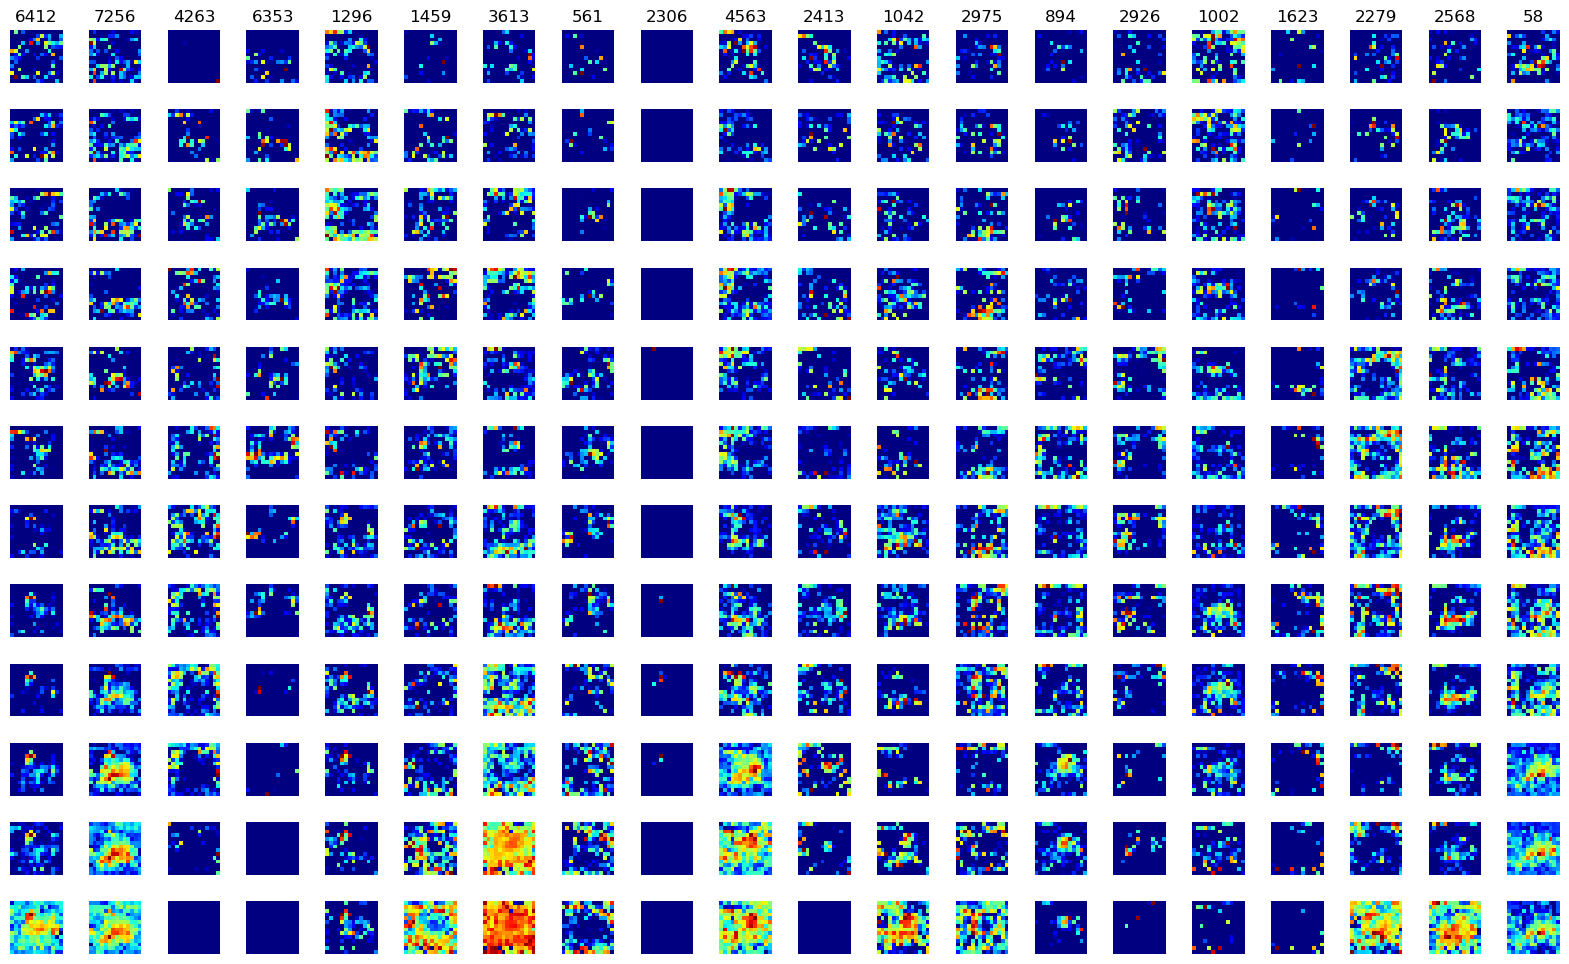

In [99]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = u_top_20_z_avg[j]
        sns.heatmap(untied_activation[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


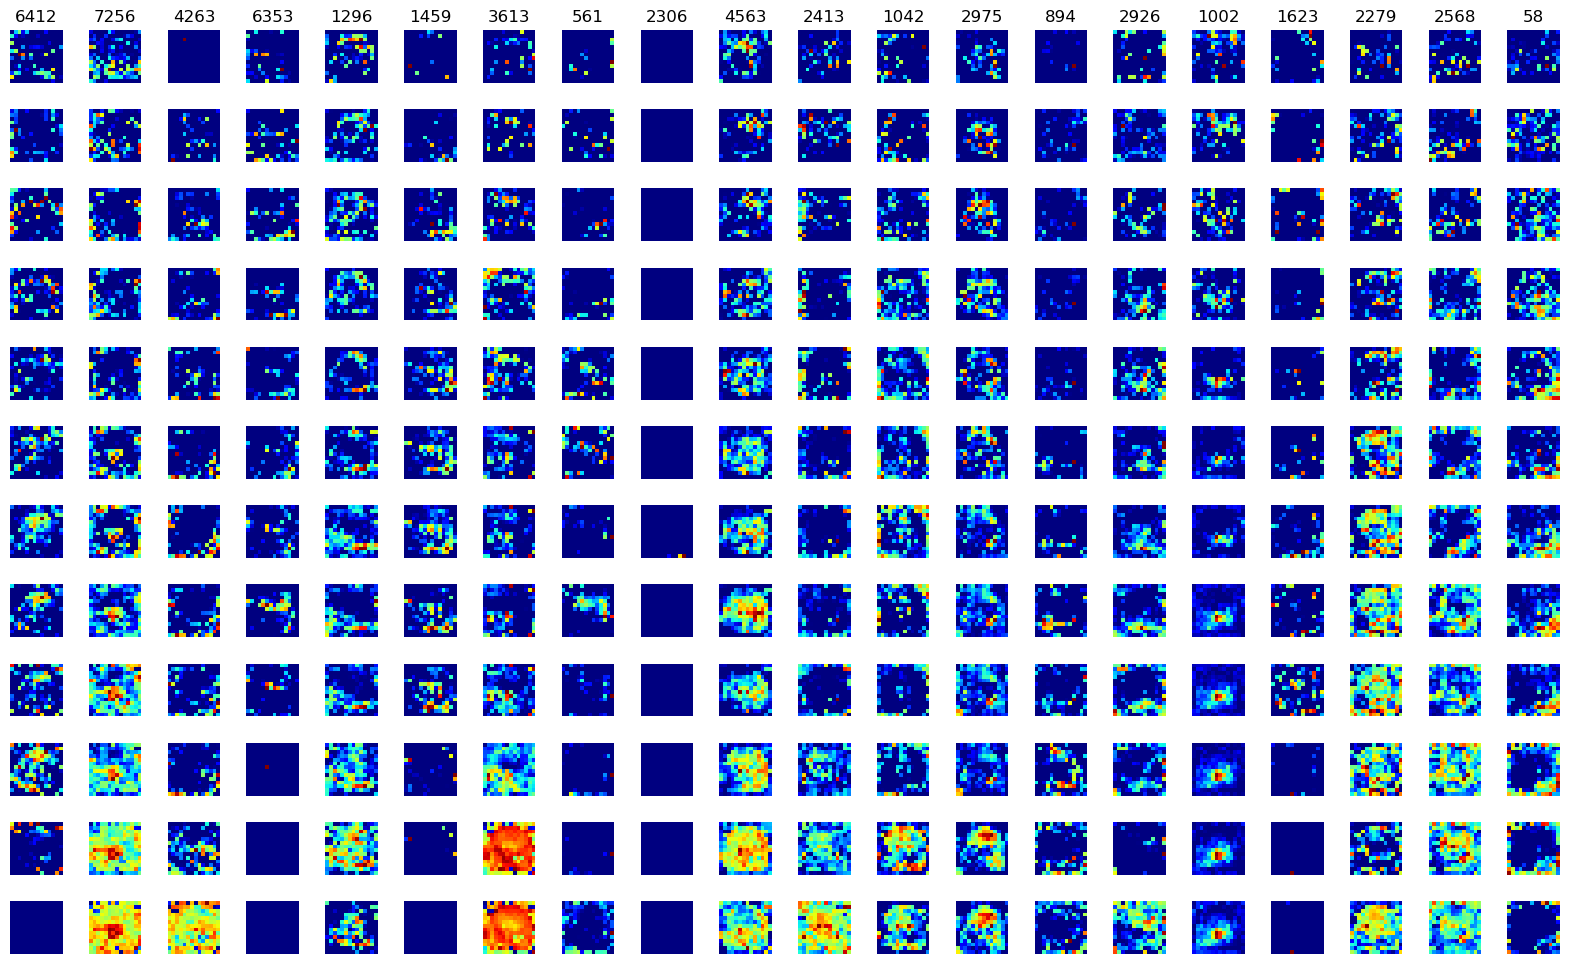

In [100]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = u_top_20_z_avg[j]
        sns.heatmap(untied_activation2[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


## bottom 20 average z scores

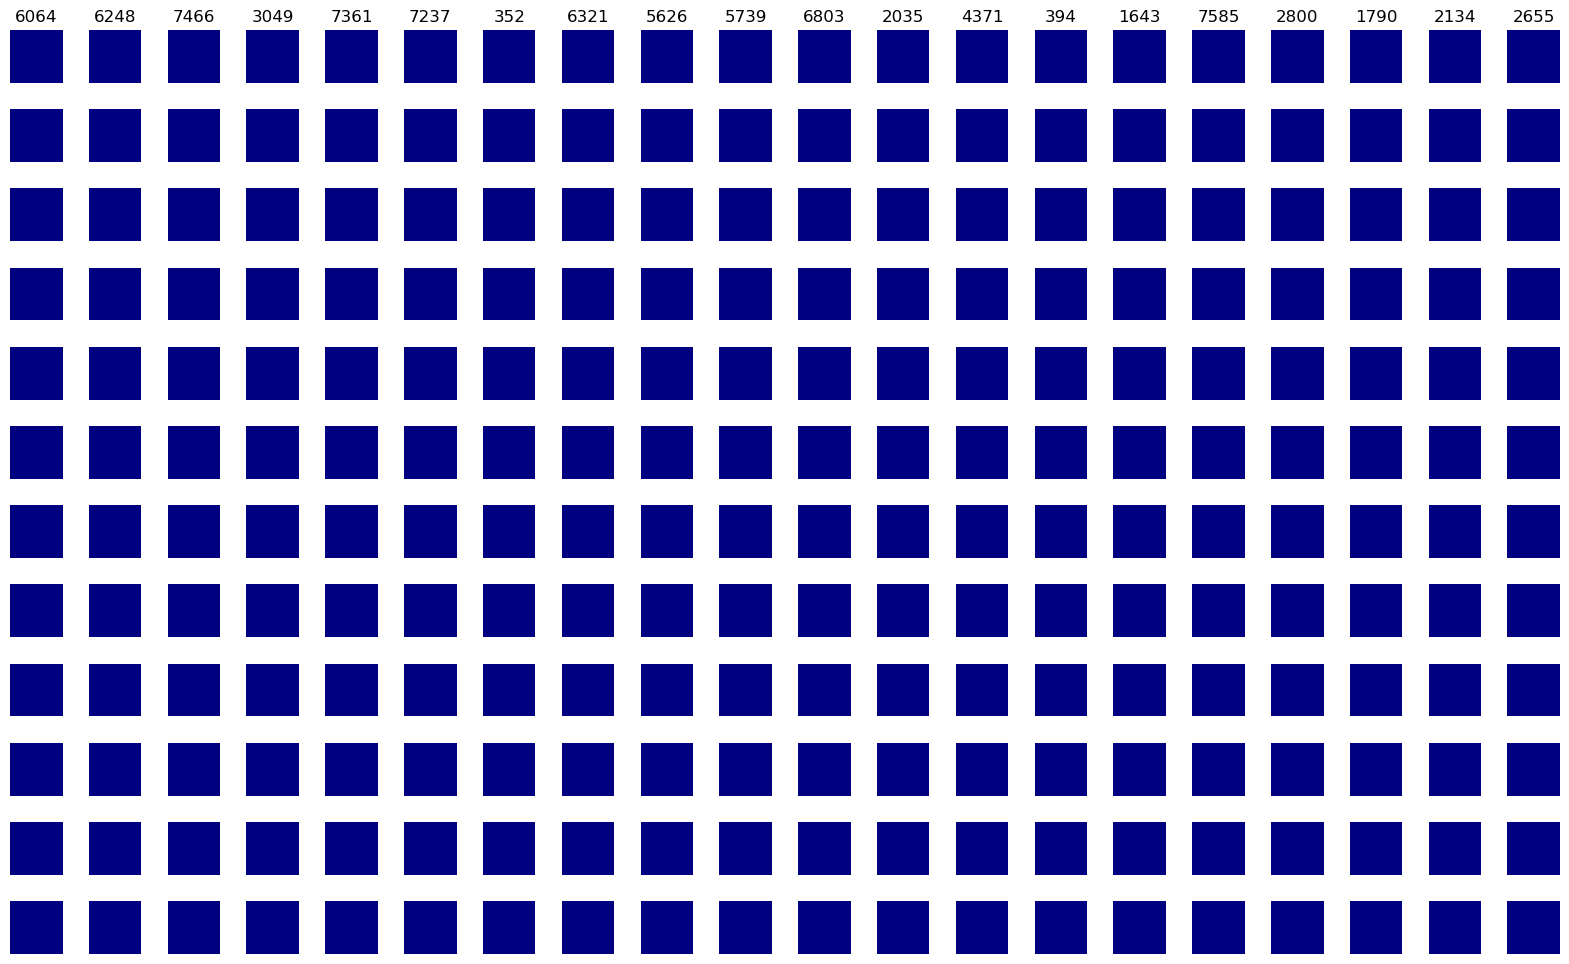

In [101]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = u_low_20_z_avg[j]
        sns.heatmap(untied_activation[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


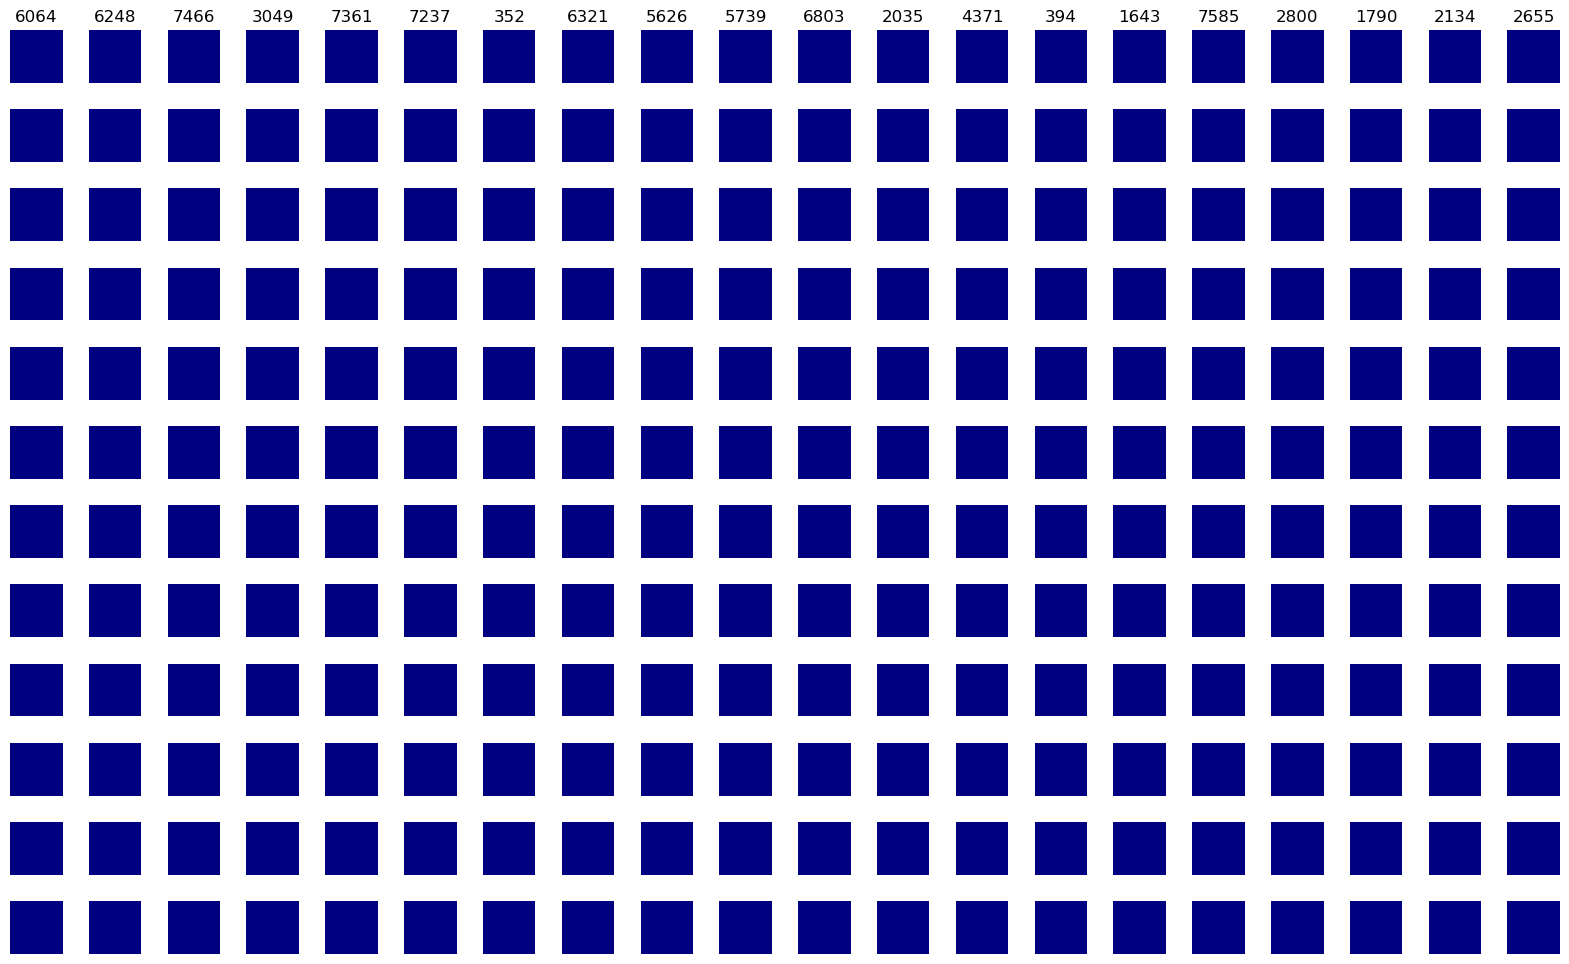

In [102]:
fig, axs = plt.subplots(12, 20, figsize=(20, 12))

for i in range(12):
    for j in range(20):
        ax = axs[i, j]
        feature = u_low_20_z_avg[j]
        sns.heatmap(untied_activation2[i][:,feature][1:].reshape(14,-1).detach().cpu().numpy(), cmap='jet', ax=ax, cbar=False)
        if i ==0:
            ax.set_title(f'{feature}')
        ax.axis('off')
plt.subplots_adjust(wspace=0.5, hspace=0.5)  # Adjust spacing between subplots
plt.show()


# metrics

In [3]:
from transformers import PreTrainedModel
from abc import ABC, abstractmethod


class Dict(ABC):
    activation_size : int
    dict_size : int

    @abstractmethod
    def encode(self, x):
        pass
    
    @abstractmethod
    def decode(self, f):
        pass

def FVU(x, x_hat):
    """Fraction of Variance Unexplained"""

    # calculate MSE between original activations and reconstructed activations 
    mse = MSE(x, x_hat)

    # compute variance of the original activations
    variance = (x - x.mean(dim=0)).pow(2).mean()

    # return ratio of the MSE to the variance of the original activations
    return mse / variance

def L0(features):
    return torch.norm(features, 0, dim=-1).mean()

def Effective_L0(features):
    # Divide the L1 of a datpoint by the max of each datapoint
    return (torch.norm(features, 1, dim=-1) / features.max(dim=-1)[0]).nanmean()

def L1(features):
    return torch.norm(features, 1, dim=-1).mean()


def MSE(x, x_hat):
    """compute mean squared error between input activations and reconstructed activations"""
    return (x - x_hat).pow(2).mean() 

def dec_bias_median_distance(x, dictionary):
    # measure the median distance between the decoder bias and the activations
    return torch.norm(x - dictionary.b_d, dim=-1).median(0).values.mean()


In [4]:

# load different SAE
cifar_sae_10_lr5 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05.pth'))
cifar_sae_10_lr5.to_device(device)

cifar_sae_10_lr4 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
cifar_sae_10_lr4.to_device(device)

cifar_sae_15_lr4 = TiedSAE(encoder, encoder_bias)
cifar_sae_15_lr4.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio15_epoch100_lr0.0001.pth'))
cifar_sae_15_lr4.to_device(device)

cifar_sae_10_lr5_layer0 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer0.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer0.pth'))
cifar_sae_10_lr5_layer0.to_device(device)

cifar_sae_10_lr5_layer1 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer1.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer1.pth'))
cifar_sae_10_lr5_layer1.to_device(device)

cifar_sae_10_lr5_layer2 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer2.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer2.pth'))
cifar_sae_10_lr5_layer2.to_device(device)

cifar_sae_10_lr5_layer3 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer3.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer3.pth'))
cifar_sae_10_lr5_layer3.to_device(device)

cifar_sae_10_lr5_layer4 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer4.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer4.pth'))
cifar_sae_10_lr5_layer4.to_device(device)

cifar_sae_10_lr5_layer5 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer5.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer5.pth'))
cifar_sae_10_lr5_layer5.to_device(device)

cifar_sae_10_lr5_layer6 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer6.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer6.pth'))
cifar_sae_10_lr5_layer6.to_device(device)   

cifar_sae_10_lr5_layer7 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer7.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer7.pth'))
cifar_sae_10_lr5_layer7.to_device(device)

cifar_sae_10_lr5_layer8 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer8.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer8.pth'))
cifar_sae_10_lr5_layer8.to_device(device)

cifar_sae_10_lr5_layer9 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer9.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer9.pth'))
cifar_sae_10_lr5_layer9.to_device(device)

cifar_sae_10_lr5_layer10 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer10.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer10.pth'))
cifar_sae_10_lr5_layer10.to_device(device)

cifar_sae_10_lr5_layer11 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr5_layer11.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr1e-05_layer11.pth'))
cifar_sae_10_lr5_layer11.to_device(device)

                

In [ ]:
# cifar 10 activation plot for top 20 absolute activation, top/bottom 20 average zscores
model = ViTForImageClassification.from_pretrained('nateraw/vit-base-patch16-224-cifar10',output_hidden_states=True)
model.eval()
model.to(device)
processor = ViTImageProcessor.from_pretrained('nateraw/vit-base-patch16-224-cifar10')
to_pil = transforms.ToPILImage()
to_tensor = transforms.ToTensor()


: 

In [7]:
dataset = load_dataset("cifar10", split="test")

class CIFAR10HFDataset(Dataset):
    def __init__(self, hf_dataset, processor):
        self.hf_dataset = hf_dataset
        self.processor = processor

    def __len__(self):
        return len(self.hf_dataset)

    def __getitem__(self, idx):
        # Extract image and label from the dataset
        image = self.hf_dataset[idx]['img']
        label = self.hf_dataset[idx]['label']

        # Preprocess the image
        inputs = self.processor(images=image, return_tensors='pt')
        # Remove the batch dimension
        inputs = inputs['pixel_values'].squeeze()

        return inputs, label
    
test_dataset = CIFAR10HFDataset(dataset, processor)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

In [8]:
inputs = next(iter(test_loader))[0]

In [9]:
inputs[0].shape

torch.Size([3, 224, 224])

In [10]:
inputs = inputs.to(device)
activations = model(inputs, output_hidden_states=True)['hidden_states'][1:]

In [11]:
activations[0].shape

torch.Size([32, 197, 768])

In [5]:
def metric_calc(model: TiedSAE, layer_num=range(12), activation_path='activations_cifar10_vit_b'):
    mse = []
    fvu = []
    l1 = []
    if isinstance(layer_num, int):
        layer_num = [layer_num]
    for layer_index in layer_num:
        for k in range(10):
            path = f'{activation_path}/cifar10_activations_{k}.h5'
            layer_name = f'vit.encoder.layer.{layer_index}.output'
            dataset = ActivationDataset(path, layer_name)
            data_loader = DataLoader(dataset, batch_size=32, num_workers=4)
            for i,(img, act) in enumerate(data_loader):
                encoded = model.encode(torch.Tensor(act).to(device))
                x_hat = model.decode(encoded)
                mse.append(MSE(torch.Tensor(act).to(device), x_hat).cpu().detach().numpy())
                fvu.append(FVU(torch.Tensor(act).to(device), x_hat).cpu().detach().numpy())
                l1.append(L1(encoded).cpu().detach().numpy())
    return np.average(mse), np.average(fvu), np.average(l1)

In [6]:
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr5)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4)}')

mse, fvu, L1: (0.42261952, 0.07556482, 1038.8904)
mse, fvu, L1: (0.18005905, 0.049500816, 805.5323)


In [7]:
cifar_sae_10_lr4_layer0 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer0.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer0.pth'))
cifar_sae_10_lr4_layer0.to_device(device)

cifar_sae_10_lr4_layer1 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer1.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer1.pth'))
cifar_sae_10_lr4_layer1.to_device(device)

cifar_sae_10_lr4_layer2 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer2.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer2.pth'))
cifar_sae_10_lr4_layer2.to_device(device)

cifar_sae_10_lr4_layer3 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer3.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer3.pth'))
cifar_sae_10_lr4_layer3.to_device(device)

cifar_sae_10_lr4_layer4 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer4.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer4.pth'))
cifar_sae_10_lr4_layer4.to_device(device)

cifar_sae_10_lr4_layer5 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer5.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer5.pth'))
cifar_sae_10_lr4_layer5.to_device(device)

cifar_sae_10_lr4_layer6 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer6.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer6.pth'))
cifar_sae_10_lr4_layer6.to_device(device)

cifar_sae_10_lr4_layer7 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer7.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer7.pth'))
cifar_sae_10_lr4_layer7.to_device(device)

cifar_sae_10_lr4_layer8 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer8.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer8.pth'))
cifar_sae_10_lr4_layer8.to_device(device)

cifar_sae_10_lr4_layer9 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer9.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer9.pth'))
cifar_sae_10_lr4_layer9.to_device(device)

cifar_sae_10_lr4_layer10 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer10.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer10.pth'))
cifar_sae_10_lr4_layer10.to_device(device)

cifar_sae_10_lr4_layer11 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4_layer11.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001_layer11.pth'))
cifar_sae_10_lr4_layer11.to_device(device)


print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer0, layer_num=0)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer1, layer_num=1)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer2, layer_num=2)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer3, layer_num=3)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer4, layer_num=4)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer5, layer_num=5)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer6, layer_num=6)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer7, layer_num=7)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer8, layer_num=8)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer9, layer_num=9)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer10, layer_num=10)}')
print(f'mse, fvu, L1: {metric_calc(cifar_sae_10_lr4_layer11, layer_num=11)}')


mse, fvu, L1: (0.021644201, 0.06183263, 68.95888)
mse, fvu, L1: (0.046325546, 0.0770418, 107.43752)
mse, fvu, L1: (0.0860949, 0.090434834, 167.74557)
mse, fvu, L1: (0.12341267, 0.087472826, 224.43832)
mse, fvu, L1: (0.14802237, 0.023784328, 301.51895)
mse, fvu, L1: (0.1670642, 0.0025286782, 428.0705)
mse, fvu, L1: (0.1855272, 0.0011270555, 556.4539)
mse, fvu, L1: (0.19312957, 0.0010822164, 677.33026)
mse, fvu, L1: (0.20342584, 0.0010850492, 841.8981)
mse, fvu, L1: (0.22356263, 0.0010849768, 1103.0515)
mse, fvu, L1: (0.25392792, 0.0012197375, 1563.5701)
mse, fvu, L1: (0.33416113, 0.0015594785, 2210.4883)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
#initiate encoder, bias 
encoder = torch.randn((7680,768))
nn.init.xavier_uniform(encoder)
encoder_bias = torch.zeros(7680)

cifar_sae_10_lr4 = TiedSAE(encoder, encoder_bias)
cifar_sae_10_lr4.load_state_dict(torch.load('SAE_models/cifar10/SAE_ratio10_epoch100_lr0.0001.pth'))
cifar_sae_10_lr4.to_device(device)

dino_sae_10_lr4 = TiedSAE(encoder, encoder_bias)
dino_sae_10_lr4.load_state_dict(torch.load('SAE_models/cifar10_dino/SAE_ratio10_epoch100_lr0.0001.pth'))
dino_sae_10_lr4.to_device(device)

mae_sae_10_lr4 = TiedSAE(encoder, encoder_bias)
mae_sae_10_lr4.load_state_dict(torch.load('SAE_models/cifar10_vitmae/SAE_ratio10_epoch100_lr0.0001.pth'))
mae_sae_10_lr4.to_device(device)


/tmp/ipykernel_445371/1515486624.py:4: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(encoder)


In [9]:
print('cifar')

print(f"mse, fvu, L1: {metric_calc(cifar_sae_10_lr4)}")

print('dino')
print(f"mse, fvu, L1: {metric_calc(dino_sae_10_lr4, activation_path='activations_cifar10_dino_vitb16')}")

print('vitmae')
print(f"mse, fvu, L1: {metric_calc(mae_sae_10_lr4, activation_path='activations_cifar10_facebook_vitmae')}")


cifar


mse, fvu, L1: (0.18005905, 0.049500816, 805.5323)
dino
mse, fvu, L1: (0.041542362, 0.29763886, 44.89829)
vitmae
mse, fvu, L1: (0.06704487, 0.14266792, 147.64165)
